## Clean and Collate data

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, geopandas as gpd, datetime, glob, math, openpyxl
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from statistics import mean
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.dpi'] = 300

In [2]:
pop_la_file = './Desktop/MSc Project/Data/LG Inform data/Population_by_local_authority.csv'
pop_la_df = pd.read_csv(pop_la_file)
pop_la_df.head(8)

area label       area Total population
0     area label       area          3281.00
1     area label       area           People
2     area label       area              raw
3     area label       area          2020.00
4     area label       area         cal_2020
5       Aberdeen  S12000033        229060.00
6  Aberdeenshire  S12000034        260780.00
7           Adur  E07000223         64187.00

In [3]:
pop_la_df = pop_la_df[5:]

#### Vaccine data

In [4]:
#get files
vac1_reg_file = './Desktop/MSc Project/Data/LG Inform data/Vaccine data//31.07.21/Vaccine_rate_dose_one_by_region_31.07.2021.csv'
vac2_reg_file = './Desktop/MSc Project/Data/LG Inform data/Vaccine data/31.07.21/Vaccine_rate_dose_two_by_region_31.07.2021.csv'
vac1_la_file = './Desktop/MSc Project/Data/LG Inform data/Vaccine data/31.07.21/Vaccine_rate_dose_one_by_local_authority_31.07.2021.csv'
vac2_la_file = './Desktop/MSc Project/Data/LG Inform data/Vaccine data/31.07.21/Vaccine_rate_dose_two_by_local_authority_31.07.2021.csv'
vac1_ua_file = './Desktop/MSc Project/Data/LG Inform data/Vaccine data/31.07.21/Vaccine_rate_dose_one_by_unitary_authority_31.07.2021.csv'
vac2_ua_file = './Desktop/MSc Project/Data/LG Inform data/Vaccine data/31.07.21/Vaccine_rate_dose_two_by_unitary_authority_31.07.2021.csv'

In [5]:
#'full' data from 04/03/21 to present

all_weekly_data = []
all_weekly_dates = []
all_weekly_pop_data = []

for i,f in enumerate(glob.glob("C:/Users/joshb/Desktop/MSc Project/Data/PHE/Weekly/Full data/*.xlsx")):
    if i%2==0:
        print(i+10, end=' ')
    
    all_weekly_dates.append(list(pd.read_excel(f, engine='openpyxl', sheet_name='LTLA',
                                      index_col=None, usecols = "C", header = 6, nrows=0).columns)[0])
    
    all_weekly_data.append(pd.read_excel(f, engine='openpyxl', sheet_name='LTLA',header=[10,11]))
    
    all_weekly_pop_data.append(pd.read_excel(f, engine='openpyxl', sheet_name='Population estimates (NIMS)',
                                             header=[11,12]))

10 12 14 16 18 20 22 24 26 28 30 32 34 

In [6]:
#put files into dataframes
files = [vac1_reg_file, vac2_reg_file, vac1_la_file, vac2_la_file, vac1_ua_file, vac2_ua_file,]

vac1_reg_df = pd.read_csv(files[0])
vac2_reg_df = pd.read_csv(files[1])
vac1_la_df = pd.read_csv(files[2])
vac2_la_df = pd.read_csv(files[3])
vac1_ua_df = pd.read_csv(files[4])
vac2_ua_df = pd.read_csv(files[5])

dfs =   [vac1_reg_df, vac2_reg_df, vac1_la_df, vac2_la_df, vac1_ua_df, vac2_ua_df ]

for i in range(0,6):
    dfs[i] = dfs[i][5:]

In [7]:
#get most recent date only

weekly_date = all_weekly_dates[-1]
weekly_data = all_weekly_data[-1]
weekly_pop_data = all_weekly_pop_data[-1]

In [8]:
#make LTLA names the index

weekly_data = weekly_data.set_index(
    weekly_data.iloc[:, weekly_data.columns.get_level_values(0).str.startswith('LTLA name')].columns[0])

weekly_pop_data = weekly_pop_data.set_index(
    weekly_pop_data.iloc[:, weekly_pop_data.columns.get_level_values(0).str.startswith('LTLA name')].columns[0])

In [9]:
weekly_pop_data = weekly_pop_data['Population estimates']

In [10]:
weekly_pop_data = weekly_pop_data[weekly_pop_data.columns[~weekly_pop_data.columns.str.contains('\.')]]

In [11]:
weekly_pop_data = weekly_pop_data.drop(['18+','16+'],axis=1)

In [12]:
weekly_pop_data = weekly_pop_data.loc[weekly_pop_data.index.dropna()]

In [13]:
idx =  weekly_pop_data.index

In [14]:
weekly_pop_data = weekly_pop_data.sum(axis=1)

In [15]:
weekly_data.head()

Unnamed: 0_level_0  \
                                   Unnamed: 0_level_1   
(LTLA name4,5, Unnamed: 6_level_1)                      
NaN                                               NaN   
NaN                                               NaN   
Amber Valley                                      NaN   
Ashfield                                          NaN   
Bassetlaw                                         NaN   

                                   Region code (administrative)  \
                                             Unnamed: 1_level_1   
(LTLA name4,5, Unnamed: 6_level_1)                                
NaN                                                      Total6   
NaN                                                         NaN   
Amber Valley                                          E12000004   
Ashfield                                              E12000004   
Bassetlaw                                             E12000004   

                                   Region name (administrative)  \
                                             Unnamed: 2_level_1   
(LTLA name4,5, Unnamed: 6_level_1)                                
NaN                                                         NaN   
NaN                                                         NaN   
Amber Valley                                      East Midlands   
Ashfield                                          East Midlands   
Bassetlaw                                         East Midlands   

                                            UTLA code          UTLA name  \
                                   Unnamed: 3_level_1 Unnamed: 4_level_1   
(LTLA name4,5, Unnamed: 6_level_1)                                         
NaN                                               NaN                NaN   
NaN                                               NaN                NaN   
Amber Valley                                E10000007         Derbyshire   
Ashfield                                    E10000024    Nottinghamshire   
Bassetlaw                                   E10000024    Nottinghamshire   

                                         LTLA code4,5 1st dose7             \
                                   Unnamed: 5_level_1  Under 18      18-24   
(LTLA name4,5, Unnamed: 6_level_1)                                           
NaN                                               NaN  344870.0  3324361.0   
NaN                                               NaN       NaN        NaN   
Amber Valley                                E07000032     920.0     6897.0   
Ashfield                                    E07000170     780.0     6748.0   
Bassetlaw                                   E07000171     788.0     6247.0   

                                                          ...  \
                                        25-29      30-34  ...   
(LTLA name4,5, Unnamed: 6_level_1)                        ...   
NaN                                 2764031.0  3090673.0  ...   
NaN                                       NaN        NaN  ...   
Amber Valley                           5659.0     6263.0  ...   
Ashfield                               5613.0     6620.0  ...   
Bassetlaw                              5208.0     5718.0  ...   

                                   Cumulative total doses to date9  \
                                               Unnamed: 53_level_1   
(LTLA name4,5, Unnamed: 6_level_1)                                   
NaN                                                            NaN   
NaN                                                            NaN   
Amber Valley                                                   NaN   
Ashfield                                                       NaN   
Bassetlaw                                                      NaN   

                                                                            \
                                   Unnamed: 54_level_1 Unnamed: 55_level_1   
(LTLA name4,5, Unnamed: 6_level_

In [16]:
weekly_data.columns.get_level_values(0).str.startswith(('1st', '2nd'))

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [17]:
#we only care about 1st and 2nd dose numbers atm
weekly_data = weekly_data.iloc[:, weekly_data.columns.get_level_values(0).str.startswith(('1st', '2nd'))]

In [18]:
weekly_data = weekly_data.loc[weekly_data.index.dropna()]
weekly_data.head()

1st dose7                                  \
                                    Under 18   18-24   25-29   30-34   35-39   
(LTLA name4,5, Unnamed: 6_level_1)                                             
Amber Valley                           920.0  6897.0  5659.0  6263.0  6341.0   
Ashfield                               780.0  6748.0  5613.0  6620.0  6613.0   
Bassetlaw                              788.0  6247.0  5208.0  5718.0  5801.0   
Blaby                                  523.0  5372.0  4495.0  5363.0  5663.0   
Bolsover                               609.0  4426.0  3868.0  4129.0  4135.0   

                                                                            \
                                     40-44   45-49   50-54   55-59   60-64   
(LTLA name4,5, Unnamed: 6_level_1)                                           
Amber Valley                        6608.0  7982.0  9472.0  9465.0  8235.0   
Ashfield                            6491.0  7335.0  8841.0  8790.0  7320.0   
Bassetlaw                           5887.0  6886.0  8508.0  8885.0  7594.0   
Blaby                               5660.0  6062.0  6989.0  6930.0  6137.0   
Bolsover                            3848.0  4708.0  6037.0  5792.0  5060.0   

                                    ... 2nd dose7,8                          \
                                    ...       40-44   45-49   50-54   55-59   
(LTLA name4,5, Unnamed: 6_level_1)  ...                                       
Amber Valley                        ...      6311.0  7744.0  9285.0  9212.0   
Ashfield                            ...      5992.0  6976.0  8601.0  8614.0   
Bassetlaw                           ...      5526.0  6552.0  8299.0  8695.0   
Blaby                               ...      5356.0  5815.0  6826.0  6685.0   
Bolsover                            ...      3583.0  4479.0  5890.0  5665.0   

                                                                            \
                                     60-64   65-69   70-74   75-79     80+   
(LTLA name4,5, Unnamed: 6_level_1)                                           
Amber Valley                        8110.0  7235.0  7917.0  5716.0  6528.0   
Ashfield                            7164.0  6320.0  6431.0  5100.0  5831.0   
Bassetlaw                           7459.0  6562.0  7055.0  5197.0  6154.0   
Blaby                               5997.0  5134.0  5581.0  4119.0  5378.0   
Bolsover                            4956.0  4198.0  4213.0  3360.0  3673.0   

                                          
                                   80+.1  
(LTLA name4,5, Unnamed: 6_level_1)        
Amber Valley                         NaN  
Ashfield                             NaN  
Bassetlaw                            NaN  
Blaby                                NaN  
Bolsover                             NaN  

[5 rows x 30 columns]

In [19]:
vac1_weekly_data = weekly_data.iloc[:, weekly_data.columns.get_level_values(0).str.startswith('1st')]
vac2_weekly_data = weekly_data.iloc[:, weekly_data.columns.get_level_values(0).str.startswith('2nd')]

In [20]:
vac1_weekly_data.head()

1st dose7                                  \
                                    Under 18   18-24   25-29   30-34   35-39   
(LTLA name4,5, Unnamed: 6_level_1)                                             
Amber Valley                           920.0  6897.0  5659.0  6263.0  6341.0   
Ashfield                               780.0  6748.0  5613.0  6620.0  6613.0   
Bassetlaw                              788.0  6247.0  5208.0  5718.0  5801.0   
Blaby                                  523.0  5372.0  4495.0  5363.0  5663.0   
Bolsover                               609.0  4426.0  3868.0  4129.0  4135.0   

                                                                            \
                                     40-44   45-49   50-54   55-59   60-64   
(LTLA name4,5, Unnamed: 6_level_1)                                           
Amber Valley                        6608.0  7982.0  9472.0  9465.0  8235.0   
Ashfield                            6491.0  7335.0  8841.0  8790.0  7320.0   
Bassetlaw                           5887.0  6886.0  8508.0  8885.0  7594.0   
Blaby                               5660.0  6062.0  6989.0  6930.0  6137.0   
Bolsover                            3848.0  4708.0  6037.0  5792.0  5060.0   

                                                                          
                                     65-69   70-74   75-79     80+ 80+.1  
(LTLA name4,5, Unnamed: 6_level_1)                                        
Amber Valley                        7299.0  7982.0  5749.0  6581.0   NaN  
Ashfield                            6414.0  6493.0  5153.0  5944.0   NaN  
Bassetlaw                           6633.0  7116.0  5235.0  6279.0   NaN  
Blaby                               5203.0  5621.0  4152.0  5427.0   NaN  
Bolsover                            4253.0  4245.0  3374.0  3710.0   NaN

In [21]:
vac1_weekly_data = vac1_weekly_data.drop('80+.1',axis=1,level=1)
vac2_weekly_data = vac2_weekly_data.drop('80+.1',axis=1,level=1)

In [22]:
vac1_weekly_data = vac1_weekly_data.sum(axis=1)
vac1_weekly_data

(LTLA name4,5, Unnamed: 6_level_1)
Amber Valley     95453.0
Ashfield         89155.0
Bassetlaw        86785.0
Blaby            73597.0
Bolsover         58194.0
                  ...   
Scarborough      83779.0
Selby            68504.0
Sheffield       385423.0
Wakefield       248746.0
York            149791.0
Length: 307, dtype: float64

In [23]:
vac2_weekly_data = vac2_weekly_data.sum(axis=1)
vac2_weekly_data

(LTLA name4,5, Unnamed: 6_level_1)
Amber Valley     84991.0
Ashfield         78188.0
Bassetlaw        77263.0
Blaby            67062.0
Bolsover         52189.0
                  ...   
Scarborough      77103.0
Selby            61554.0
Sheffield       326038.0
Wakefield       215493.0
York            124374.0
Length: 307, dtype: float64

In [24]:
vac_reg_df = pd.concat([vac1_reg_df, vac2_reg_df], axis=1, join="inner")
vac_la_df = pd.concat([vac1_la_df, vac2_la_df], axis=1, join="inner")
vac_ua_df = pd.concat([vac1_ua_df, vac2_ua_df], axis=1, join="inner")

In [25]:
vac_reg_df.columns = [vac_reg_df.columns[0],vac_reg_df.columns[1],vac_reg_df.columns[2],'d1','d2',vac_reg_df.columns[5]]
vac_la_df.columns = [vac_la_df.columns[0],vac_la_df.columns[1],vac_la_df.columns[2],'d1','d2',vac_la_df.columns[5]]
vac_ua_df.columns = [vac_ua_df.columns[0],vac_ua_df.columns[1],vac_ua_df.columns[2],'d1','d2',vac_ua_df.columns[5]]

In [26]:
vac_reg_df = vac_reg_df.drop(['d1','d2'],axis=1)
vac_la_df = vac_la_df.drop(['d1','d2'],axis=1)
vac_ua_df = vac_ua_df.drop(['d1','d2'],axis=1)

#### Cases data

In [27]:
#get files
cases_reg_file = './Desktop/MSc Project/Data/LG Inform data/Cases data/31.07.21/Cases_by_specimen_date_by_region_31.07.2021.csv'
cases_la_file = './Desktop/MSc Project/Data/LG Inform data/Cases data/31.07.21/Cases_by_specimen_date_by_local_authority_31.07.2021.csv'
cases_ua_file = './Desktop/MSc Project/Data/LG Inform data/Cases data/31.07.21/Cases_by_specimen_date_by_unitary_authority_31.07.2021.csv'

In [28]:
#put files into dataframes
cases_reg_df = pd.read_csv(cases_reg_file)
cases_la_df = pd.read_csv(cases_la_file)
cases_ua_df = pd.read_csv(cases_ua_file)

In [29]:
weekly_data.head()

1st dose7                                  \
                                    Under 18   18-24   25-29   30-34   35-39   
(LTLA name4,5, Unnamed: 6_level_1)                                             
Amber Valley                           920.0  6897.0  5659.0  6263.0  6341.0   
Ashfield                               780.0  6748.0  5613.0  6620.0  6613.0   
Bassetlaw                              788.0  6247.0  5208.0  5718.0  5801.0   
Blaby                                  523.0  5372.0  4495.0  5363.0  5663.0   
Bolsover                               609.0  4426.0  3868.0  4129.0  4135.0   

                                                                            \
                                     40-44   45-49   50-54   55-59   60-64   
(LTLA name4,5, Unnamed: 6_level_1)                                           
Amber Valley                        6608.0  7982.0  9472.0  9465.0  8235.0   
Ashfield                            6491.0  7335.0  8841.0  8790.0  7320.0   
Bassetlaw                           5887.0  6886.0  8508.0  8885.0  7594.0   
Blaby                               5660.0  6062.0  6989.0  6930.0  6137.0   
Bolsover                            3848.0  4708.0  6037.0  5792.0  5060.0   

                                    ... 2nd dose7,8                          \
                                    ...       40-44   45-49   50-54   55-59   
(LTLA name4,5, Unnamed: 6_level_1)  ...                                       
Amber Valley                        ...      6311.0  7744.0  9285.0  9212.0   
Ashfield                            ...      5992.0  6976.0  8601.0  8614.0   
Bassetlaw                           ...      5526.0  6552.0  8299.0  8695.0   
Blaby                               ...      5356.0  5815.0  6826.0  6685.0   
Bolsover                            ...      3583.0  4479.0  5890.0  5665.0   

                                                                            \
                                     60-64   65-69   70-74   75-79     80+   
(LTLA name4,5, Unnamed: 6_level_1)                                           
Amber Valley                        8110.0  7235.0  7917.0  5716.0  6528.0   
Ashfield                            7164.0  6320.0  6431.0  5100.0  5831.0   
Bassetlaw                           7459.0  6562.0  7055.0  5197.0  6154.0   
Blaby                               5997.0  5134.0  5581.0  4119.0  5378.0   
Bolsover                            4956.0  4198.0  4213.0  3360.0  3673.0   

                                          
                                   80+.1  
(LTLA name4,5, Unnamed: 6_level_1)        
Amber Valley                         NaN  
Ashfield                             NaN  
Bassetlaw                            NaN  
Blaby                                NaN  
Bolsover                             NaN  

[5 rows x 30 columns]

In [30]:
cases_reg_df = cases_reg_df[5:]
cases_la_df = cases_la_df[5:]
cases_ua_df = cases_ua_df[5:]

#### IMD data

In [31]:
#get files
imd_reg_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Overall/IMD_overall_score_by_region_17.07.2021.csv'
imd_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Overall/IMD_extent_by_local_authority_19.07.2021.csv'
imd_ua_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Overall/IMD_overall_score_by_unitary_authority_17.07.2021.csv'
imd_barriers_to_housing_and_services_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Individual metrics/IMD_barriers_to_housing_and_services_by_local_authority_30.07.2021.csv'
imd_crime_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Individual metrics/IMD_crime_by_local_authority_26.07.2021.csv.csv'
imd_education_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Individual metrics/IMD_education_by_local_authority_26.07.2021.csv'
imd_employment_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Individual metrics/IMD_employment_by_local_authority_30.07.2021.csv'
imd_health_deprivation_and_disability_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Individual metrics/IMD_health_deprivation_and_disability_by_local_authority_30.07.2021.csv'
imd_income_deprivation_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Individual metrics/IMD_income_deprivation_by_local_authority_30.07.2021.csv'
imd_living_environment_deprivation_la_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Individual metrics/IMD_living_environment_deprivation_by_local_authority_30.07.2021.csv'

In [32]:
#put files into dataframes
imd_reg_df = pd.read_csv(imd_reg_file)
imd_la_df = pd.read_csv(imd_la_file)
imd_ua_df = pd.read_csv(imd_ua_file)
imd_barriers_to_housing_and_services_la_df = pd.read_csv(imd_barriers_to_housing_and_services_la_file)
imd_crime_la_df = pd.read_csv(imd_crime_la_file)
imd_education_la_df = pd.read_csv(imd_education_la_file)
imd_employment_la_df = pd.read_csv(imd_employment_la_file)
imd_health_deprivation_and_disability_la_df = pd.read_csv(imd_health_deprivation_and_disability_la_file)
imd_income_deprivation_la_df = pd.read_csv(imd_income_deprivation_la_file)
imd_living_environment_deprivation_la_df = pd.read_csv(imd_living_environment_deprivation_la_file)

In [33]:
imd_la_df = pd.concat([imd_la_df,
                       imd_barriers_to_housing_and_services_la_df,
                       imd_crime_la_df,
                       imd_education_la_df,
                       imd_employment_la_df,
                       imd_health_deprivation_and_disability_la_df,
                       imd_income_deprivation_la_df,
                       imd_living_environment_deprivation_la_df],
                      join='inner', axis=1)

In [34]:
imd_reg_df = imd_reg_df[5:]
imd_la_df = imd_la_df[5:]
imd_ua_df = imd_ua_df[5:]

#### Collate data

In [35]:
reg_df = pd.concat([vac_reg_df.iloc[:,0:4], cases_reg_df.iloc[:,2], imd_reg_df.iloc[:,2]], axis=1, join="inner")

In [36]:
vac2_la_df.head()

area label  area  \
0  area label  area   
1  area label  area   
2  area label  area   
3  area label  area   
4  area label  area   

  Cumulative no. residents who have received two doses of a COVID-19 vaccine  
0                                           15254.00                          
1                                              Count                          
2                                                raw                          
3                                Week end 25/07/2021                          
4                                  weekly_2021_07_25

In [37]:
la_df = pd.concat([vac_la_df.iloc[:,0:4], cases_la_df.iloc[:,2], imd_la_df.iloc[:,2:24:3], pop_la_df.iloc[:,2]], axis=1, join="inner")

In [38]:
ua_df = pd.concat([vac_ua_df.iloc[:,0:4], cases_ua_df.iloc[:,2], imd_ua_df.iloc[:,2]], axis=1, join="inner")

In [39]:
reg_df = reg_df.replace({'Suppressed':np.nan,'Not Applicable':np.nan,'no value':np.nan})
reg_df = reg_df.rename(
    columns={
        'Cumulative no. residents who have received one dose of a COVID-19 vaccine':'Cumulative 1st dose',
        'Cumulative no. residents who have received two doses of a COVID-19 vaccine':'Cumulative 2nd dose',
        'Cumulative cases of COVID-19 by specimen date, total confirmed':'Cumulative confirmed cases',
        'area':'area code'
    })

la_df = la_df.replace({'Suppressed':np.nan,'Not Applicable':np.nan,'no value':np.nan})
la_df = la_df.rename(
    columns={
        'Cumulative no. residents who have received one dose of a COVID-19 vaccine':'Cumulative 1st dose',
        'Cumulative no. residents who have received two doses of a COVID-19 vaccine':'Cumulative 2nd dose',
        'Cumulative cases of COVID-19 by specimen date, total confirmed':'Cumulative confirmed cases',
        'area':'area code'
    })

ua_df = ua_df.replace({'Suppressed':np.nan,'Not Applicable':np.nan,'no value':np.nan})
ua_df = ua_df.rename(
    columns={
        'Cumulative no. residents who have received one dose of a COVID-19 vaccine':'Cumulative 1st dose',
        'Cumulative no. residents who have received two doses of a COVID-19 vaccine':'Cumulative 2nd dose',
        'Cumulative cases of COVID-19 by specimen date, total confirmed':'Cumulative confirmed cases',
        'area':'area code'
    })

In [40]:
vac_la_df.head()

area label  area  \
0  area label  area   
1  area label  area   
2  area label  area   
3  area label  area   
4  area label  area   

  Cumulative no. residents who have received one dose of a COVID-19 vaccine  \
0                                           14814.00                          
1                                              Count                          
2                                                raw                          
3                                Week end 25/07/2021                          
4                                  weekly_2021_07_25                          

  Cumulative no. residents who have received two doses of a COVID-19 vaccine  
0                                           15254.00                          
1                                              Count                          
2                                                raw                          
3                                Week end 25/07/2021                          
4                                  weekly_2021_07_25

In [41]:
reg_df['area label'] = reg_df['area label'].str.rstrip(' (ADASS Region)')

In [42]:
reg_df['area label'][5] = 'East of England'
reg_df['area label'][7] = 'London'
reg_df['area label'][13] = 'Yorkshire and The Humber'

In [43]:
reg_df.to_csv('./Desktop/MSc Project/Data/LG Inform data/pd2tab_reg_df.csv', index = False)
la_df.to_csv('./Desktop/MSc Project/Data/LG Inform data/pd2tab_la_df.csv', index = False)
ua_df.to_csv('./Desktop/MSc Project/Data/LG Inform data/pd2tab_ua_df.csv', index = False)

In [44]:
la_df.columns

Index(['area label', 'area code', 'Cumulative 1st dose', 'Cumulative 2nd dose',
       'Cumulative confirmed cases', 'IMD: Overall - extent (%)',
       'IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally',
       'IMD: Crime - proportion of LSOAs in most deprived 10% nationally',
       'IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally',
       'IMD: Employment - proportion of LSOAs in most deprived 10% nationally',
       'IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally',
       'IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally',
       'IMD: Living Environment Deprivation - proportion of LSOAs in most deprived 10% nationally',
       'Total population'],
      dtype='object')

In [45]:
cols2convert =['Cumulative 1st dose', 'Cumulative 2nd dose',
               'Cumulative confirmed cases', 'IMD: Overall - extent (%)',
               'IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally',
               'IMD: Crime - proportion of LSOAs in most deprived 10% nationally',
               'IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally',
               'IMD: Employment - proportion of LSOAs in most deprived 10% nationally',
               'IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally',
               'IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally',
               'IMD: Living Environment Deprivation - proportion of LSOAs in most deprived 10% nationally',
               'Total population'
              ]

la_df[cols2convert] = la_df[cols2convert].apply(lambda col: pd.to_numeric(col, errors='coerce'))

In [46]:
# TESTING
# AT THIS POINT CORNWALL WORKS IN LA_DF

#### Calculating IMD: Overall - extent (%) for North Northamptonshire, West Northamptonshire and Buckinghamshire

In [47]:
imd_2019_file = './Desktop/MSc Project/Data/LG Inform data/IMD data/Copy of File_1_-_IMD2019_Index_of_Multiple_Deprivation.csv'
imd_2019_la_df = pd.read_csv(imd_2019_file)

In [48]:
north_northamptonshire_areas = 'Corby|East Northamptonshire|Kettering|Wellingborough'
west_northamptonshire_areas = 'Daventry|Northampton|South Northamptonshire'
buckinghamshire_areas = 'South Bucks|Chiltern|Wycombe|Aylesbury Vale'

north_northamptonshire_df = imd_2019_la_df[
    imd_2019_la_df[
        'Local Authority District name (2019)'
    ]
    .str.contains(north_northamptonshire_areas, regex=True) == True
]

west_northamptonshire_df = imd_2019_la_df[
    imd_2019_la_df[
        'Local Authority District name (2019)'
    ]
    .str.contains(west_northamptonshire_areas, regex=True) == True
]

buckinghamshire_df = imd_2019_la_df[
    imd_2019_la_df[
        'Local Authority District name (2019)'
    ]
    .str.contains(buckinghamshire_areas, regex=True) == True
]

In [49]:
west_northamptonshire_df = west_northamptonshire_df[
    ~west_northamptonshire_df['Local Authority District name (2019)'].astype(str).str.startswith('East')]

In [50]:
#rough notes
def extent_score(rank):
    pct = 328.44
    
    if rank <= 10*pct:
        return 1
    
    for i in range(10, 31):
        if (i*pct < rank <=(i+1)*pct):
            1-((i-10)*0.05)

In [51]:
north_northamptonshire_df[
    'Extent score'] = north_northamptonshire_df['Index of Multiple Deprivation (IMD) Rank'].apply(extent_score)

west_northamptonshire_df[
    'Extent score'] = west_northamptonshire_df['Index of Multiple Deprivation (IMD) Rank'].apply(extent_score)

buckinghamshire_df[
    'Extent score'] = buckinghamshire_df['Index of Multiple Deprivation (IMD) Rank'].apply(extent_score)

C:\Users\joshb\AppData\Local\Temp/ipykernel_7276/263171101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_northamptonshire_df[
C:\Users\joshb\AppData\Local\Temp/ipykernel_7276/263171101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buckinghamshire_df[


In [52]:
north_northamptonshire_extent_pcnt = north_northamptonshire_df['Extent score'].sum()/(len(north_northamptonshire_df.index))*100
west_northamptonshire_extent_pcnt = west_northamptonshire_df['Extent score'].sum()/(len(west_northamptonshire_df.index))*100
buckinghamshire_extent_pcnt = buckinghamshire_df['Extent score'].sum()/(len(buckinghamshire_df.index))*100

In [53]:
buckinghamshire_extent_pcnt

0.0

In [54]:
la_df['area label'][la_df['area label'].str.contains('Buckinghamshire') == True].index

Int64Index([53], dtype='int64')

In [55]:
la_df.loc[
    la_df.loc[
        :,'area label'
    ][
        la_df.loc[
            :,'area label'
        ].str.contains('Buckinghamshire') == True
    ].index, 'IMD: Overall - extent (%)'
] = buckinghamshire_extent_pcnt

In [56]:
la_df.loc[
    la_df.loc[
        :,'area label'
    ][
        la_df.loc[
            :,'area label'
        ].str.contains('North Northamptonshire') == True
    ].index, 'IMD: Overall - extent (%)'
] = north_northamptonshire_extent_pcnt

In [57]:
la_df.loc[
    la_df.loc[
        :,'area label'
    ][
        la_df.loc[
            :,'area label'
        ].str.contains('West Northamptonshire') == True
    ].index, 'IMD: Overall - extent (%)'
] = west_northamptonshire_extent_pcnt

---

In [58]:
vac1_weekly_data.name = 'vac1_weekly_data'

In [59]:
vac1_weekly_data

(LTLA name4,5, Unnamed: 6_level_1)
Amber Valley     95453.0
Ashfield         89155.0
Bassetlaw        86785.0
Blaby            73597.0
Bolsover         58194.0
                  ...   
Scarborough      83779.0
Selby            68504.0
Sheffield       385423.0
Wakefield       248746.0
York            149791.0
Name: vac1_weekly_data, Length: 307, dtype: float64

In [60]:
vac2_weekly_data.name = 'vac2_weekly_data'

In [61]:
vac2_weekly_data

(LTLA name4,5, Unnamed: 6_level_1)
Amber Valley     84991.0
Ashfield         78188.0
Bassetlaw        77263.0
Blaby            67062.0
Bolsover         52189.0
                  ...   
Scarborough      77103.0
Selby            61554.0
Sheffield       326038.0
Wakefield       215493.0
York            124374.0
Name: vac2_weekly_data, Length: 307, dtype: float64

In [62]:
weekly_pop_data.name = 'weekly_pop_data'

In [63]:
vac1_weekly_data = vac1_weekly_data.rename(index={
    'Cornwall/Isles of Scilly':'Cornwall',
    'Bristol, City of':'Bristol',
    'County Durham':'Durham',
    'Bedford':'Bedford Borough',
#    'City of London/Hackney':'City of London'
})

vac2_weekly_data = vac2_weekly_data.rename(index={
    'Cornwall/Isles of Scilly':'Cornwall',
    'Bristol, City of':'Bristol',
    'County Durham':'Durham',
    'Bedford':'Bedford Borough',
#    'City of London/Hackney':'City of London'
})

weekly_pop_data = weekly_pop_data.rename(index={
    'Cornwall/Isles of Scilly':'Cornwall',
    'Bristol, City of':'Bristol',
    'County Durham':'Durham',
    'Bedford':'Bedford Borough',
#    'City of London/Hackney':'City of London'
})

In [64]:
la_df = la_df.join(vac1_weekly_data, on='area label')

In [65]:
la_df = la_df.join(vac2_weekly_data, on='area label')

In [66]:
la_df = la_df.join(weekly_pop_data, on='area label')

In [67]:
la_df = la_df.drop(['Cumulative 1st dose','Cumulative 2nd dose','Total population'],axis=1)

In [68]:
la_df = la_df.rename(columns = {'vac1_weekly_data':'Cumulative 1st dose',
                                'vac2_weekly_data':'Cumulative 2nd dose',
                                'weekly_pop_data':'Total population'})

In [69]:
la_df['Cumulative 1st dose per 100k'] = (la_df['Cumulative 1st dose']/la_df['Total population'])*100000
la_df['Cumulative 2nd dose per 100k'] = (la_df['Cumulative 2nd dose']/la_df['Total population'])*100000
la_df['Cumulative confirmed cases per 100k'] = (la_df['Cumulative confirmed cases']/la_df['Total population'])*100000
la_df['IMD: Overall - extent (%) per 100k'] = (la_df['IMD: Overall - extent (%)']/la_df['Total population'])*100000
la_df['Cumulative 1st dose by Cumulative 2nd dose'] = (la_df['Cumulative 1st dose']/la_df['Cumulative 2nd dose'])
la_df['Cumulative 1st dose by Cumulative confirmed cases'] = (la_df['Cumulative 1st dose']/la_df['Cumulative confirmed cases'])
la_df['IMD: Overall - extent (%) by Cumulative 1st dose'] = (la_df['IMD: Overall - extent (%)']/la_df['Cumulative 1st dose'])
la_df['Cumulative 2nd dose by Cumulative confirmed cases'] = (la_df['Cumulative 2nd dose']/la_df['Cumulative confirmed cases'])
la_df['IMD: Overall - extent (%) by Cumulative 2nd dose'] = (la_df['IMD: Overall - extent (%)']/la_df['Cumulative 2nd dose'])
la_df['IMD: Overall - extent (%) by Cumulative confirmed cases'] = (la_df['IMD: Overall - extent (%)']/la_df['Cumulative confirmed cases'])
la_df.head(3)

area label  area code  Cumulative confirmed cases  \
5       Aberdeen  S12000033                         NaN   
6  Aberdeenshire  S12000034                         NaN   
7           Adur  E07000223                      4126.0   

   IMD: Overall - extent (%)  \
5                        NaN   
6                        NaN   
7                        7.9   

   IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally  \
5                                                NaN                                             
6                                                NaN                                             
7                                                0.0                                             

   IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
5                                                NaN                  
6                                                NaN                  
7                                                0.0                  

   IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
5                                                NaN                                                      
6                                                NaN                                                      
7                                               7.14                                                      

   IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
5                                                NaN                       
6                                                NaN                       
7                                                0.0                       

   IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
5                                                NaN                                              
6                                                NaN                                              
7                                                0.0                                              

   IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
5                                                NaN                               
6                                                NaN                               
7                                                0.0                               

   ...  Cumulative 1st dose per 100k  Cumulative 2nd dose per 100k  \
5  ...                           NaN                           NaN   
6  ...                           NaN                           NaN   
7  ...                  70928.125928                  63314.523315   

   Cumulative confirmed cases per 100k  IMD: Overall - extent (%) per 100k  \
5                                  NaN                                 NaN   
6                                  NaN                                 NaN   
7                          6127.116127                           11.731512   

   Cumulative 1st dose by Cumulative 2nd dose  \
5                                         NaN   
6                                         NaN   
7                                     1.12025   

   Cumulative 1st dose by Cumulative confirmed cases  \
5                                                NaN   
6                                                NaN   
7                                          11.576103   

   IMD: Overall - extent (%) by Cumulative 1st dose  \
5                                               NaN   
6                                               NaN   
7                                          0.000165   

   Cumulative 2nd dose by Cumulative confirmed cases  \
5                                                NaN   
6                                                NaN   
7                                          10.333495   

   IMD: Overall - extent (%) by 

In [70]:
#CORNWALL IS BROKEN HERE

la_df[la_df['area label'].str.contains('Corn')].iloc[:,5:]

IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
84                                               0.61                  

    IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
84                                               3.37                                                      

    IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
84                                               6.75                       

    IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
84                                               3.37                                              

    IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
84                                               4.91                               

    IMD: Living Environment Deprivation - proportion of LSOAs in most deprived 10% nationally  \
84                                              48.16                                           

    Cumulative 1st dose  Cumulative 2nd dose  Total population  \
84             428387.0             372930.0          599785.0   

    Cumulative 1st dose per 100k  Cumulative 2nd dose per 100k  \
84                  71423.426728                  62177.280192   

    Cumulative confirmed cases per 100k  IMD: Overall - extent (%) per 100k  \
84                          3928.074227                            2.200789   

    Cumulative 1st dose by Cumulative 2nd dose  \
84                                    1.148706   

    Cumulative 1st dose by Cumulative confirmed cases  \
84                                           18.18281   

    IMD: Overall - extent (%) by Cumulative 1st dose  \
84                                          0.000031   

    Cumulative 2nd dose by Cumulative confirmed cases  \
84                                          15.828947   

    IMD: Overall - extent (%) by Cumulative 2nd dose  \
84                                          0.000035   

    IMD: Overall - extent (%) by Cumulative confirmed cases  
84                                            0.00056

### Experimenting with Geopandas

##### Regions

In [71]:
# set the filepath and load in a shapefile
fp = "./Regions_(December_2017)_Boundaries.shp"
map_df = gpd.read_file(fp)

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head(3)

objectid    rgn17cd                   rgn17nm   bng_e   bng_n     long  \
0         1  E12000001                North East  417313  600358 -1.72890   
1         2  E12000002                North West  350015  506280 -2.77237   
2         3  E12000003  Yorkshire and The Humber  446903  448736 -1.28712   

         lat    st_areasha    st_lengths  \
0  55.297031  8.608115e+09  6.492916e+05   
1  54.449451  1.418139e+10  1.053043e+06   
2  53.932640  1.543025e+10  8.646500e+05   

                                            geometry  
0  MULTIPOLYGON (((400869.793 652744.481, 400910....  
1  MULTIPOLYGON (((363823.401 578129.102, 364542....  
2  POLYGON ((479999.978 517670.160, 481340.496 51...

<AxesSubplot:>

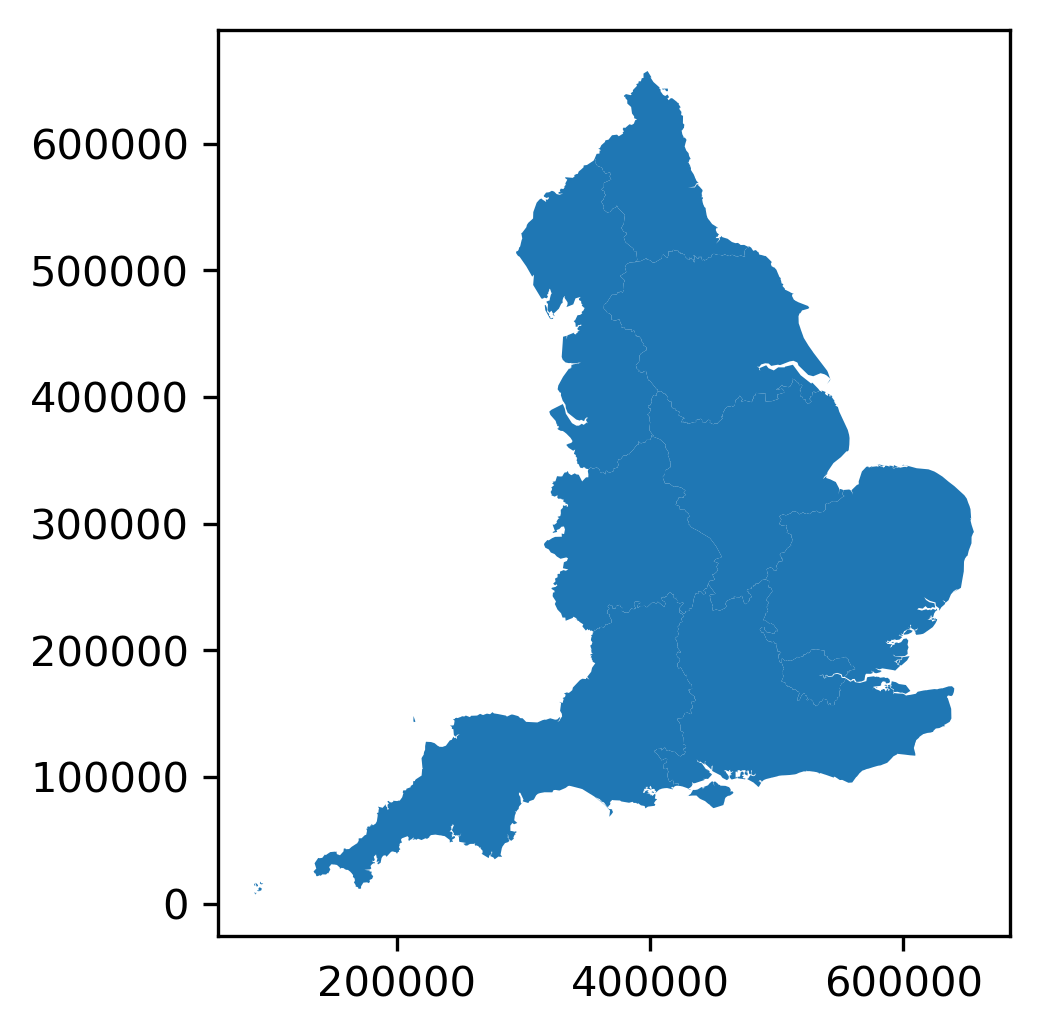

In [72]:
map_df.plot()

In [73]:
# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index('rgn17nm').join(reg_df.set_index('area label'))
merged.head(1)

objectid    rgn17cd   bng_e   bng_n    long        lat  \
rgn17nm                                                              
North East         1  E12000001  417313  600358 -1.7289  55.297031   

              st_areasha     st_lengths  \
rgn17nm                                   
North East  8.608115e+09  649291.610804   

                                                     geometry     area code  \
rgn17nm                                                                       
North East  MULTIPOLYGON (((400869.793 652744.481, 400910....  ADASS-172179   

           Cumulative 1st dose Cumulative 2nd dose Cumulative confirmed cases  \
rgn17nm                                                                         
North East          1888062.00           1,523,464                  297042.00   

           IMD: Overall - score  
rgn17nm                          
North East                28.04

In [74]:
merged['Cumulative 1st dose'] = pd.to_numeric(merged['Cumulative 1st dose'], errors='coerce')
merged['Cumulative 2nd dose'] = pd.to_numeric(merged['Cumulative 2nd dose'], errors='coerce')
merged['Cumulative confirmed cases'] = pd.to_numeric(merged['Cumulative confirmed cases'], errors='coerce')
merged['IMD: Overall - score'] = pd.to_numeric(merged['IMD: Overall - score'], errors='coerce')

In [75]:
#a function for creating map plots with geopandas

path = 'C:/Users/joshb/Desktop/MSc Project/Outputs/'

def plotmap(variable, df, title, output_file):

    # set the range for the choropleth
    vmin, vmax = df[variable].min(), df[variable].max()

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(7.5, 4.5))

    # create map
    df.plot(column=variable, cmap='coolwarm', ax=ax, linewidth=0.2, edgecolor='0.8')

    # remove the axis and add a title
    ax.axis('off')
#    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

    # create an annotation for the data source
    ax.annotate('Source: LG Inform',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', 
                verticalalignment='top', fontsize=12, color='#555555')

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # empty array for the data ranges
    sm._A = []

    # add the colorbar to the figure
    cbar = fig.colorbar(sm)

    fig.savefig(path+output_file, dpi=300)

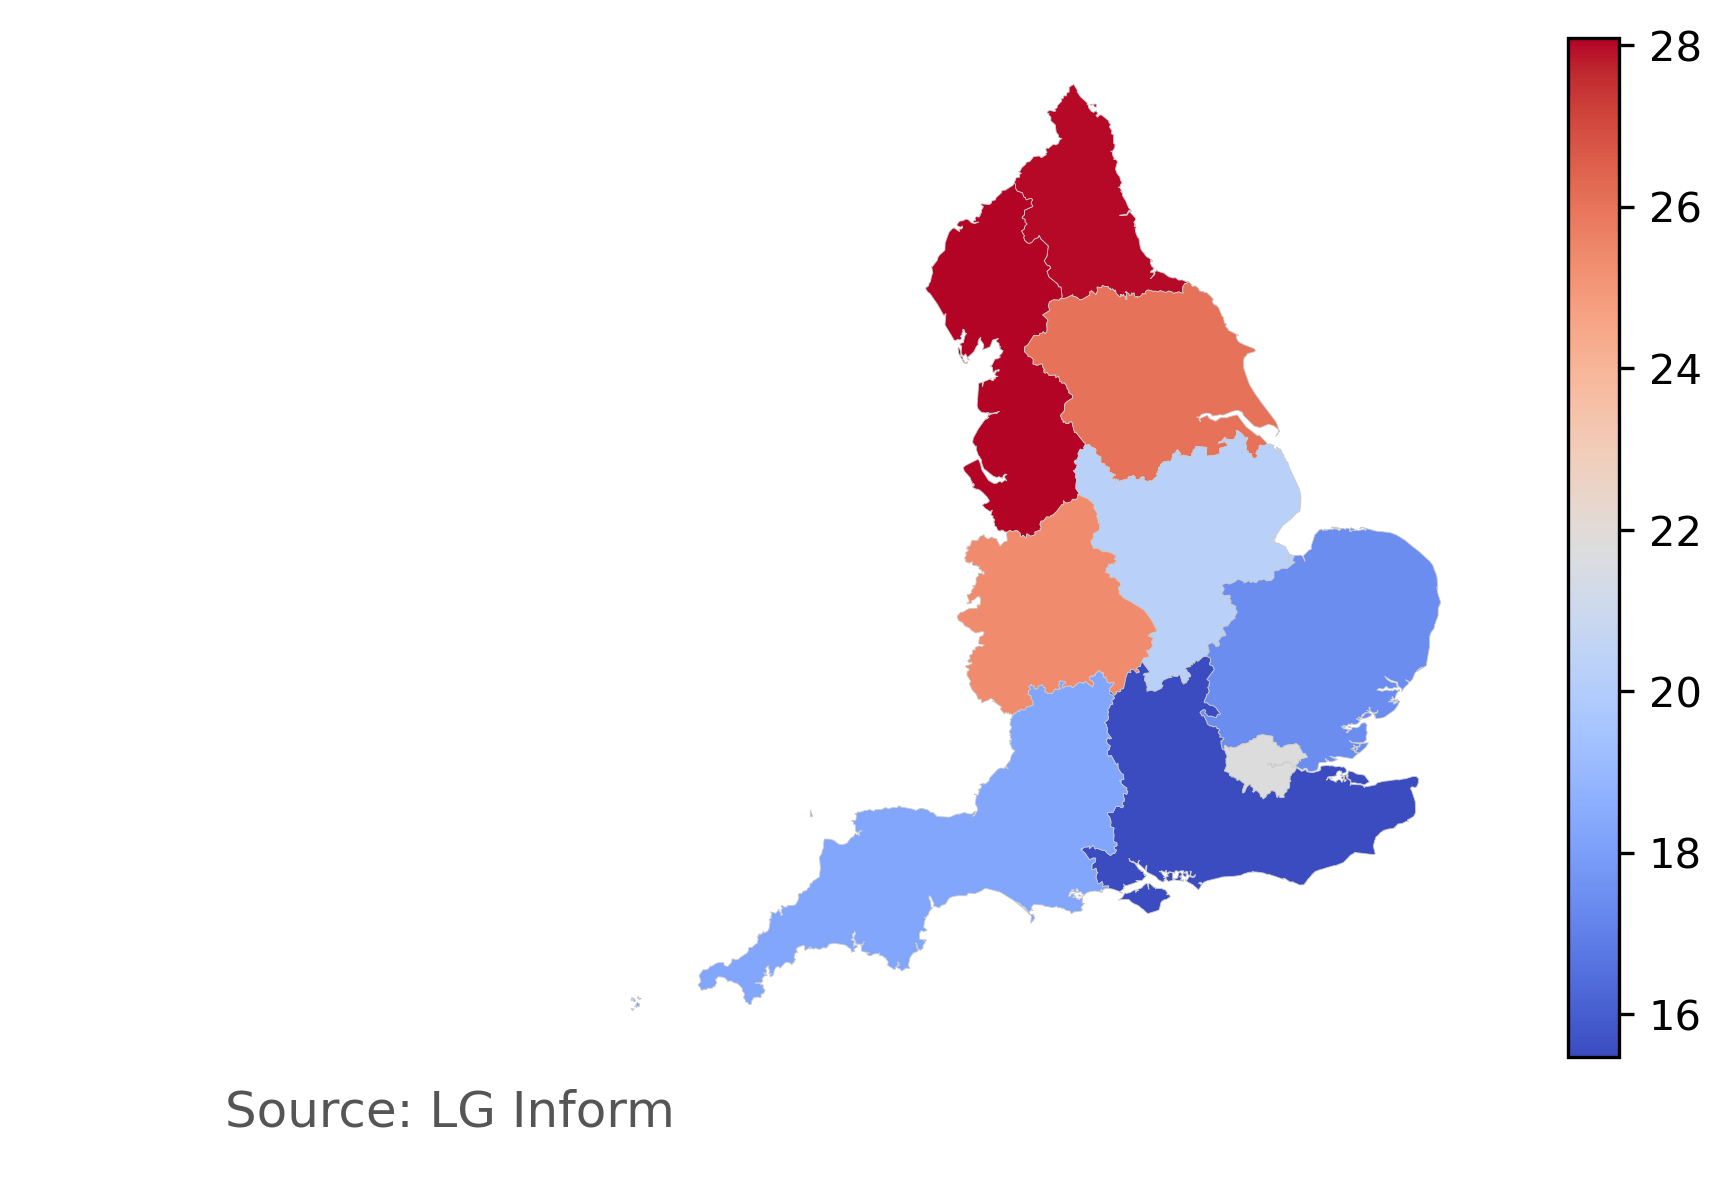

In [76]:
plotmap(variable='IMD: Overall - score', df=merged, 
        title='IMD: Overall - score per Region', output_file="IMD_map_region.png")

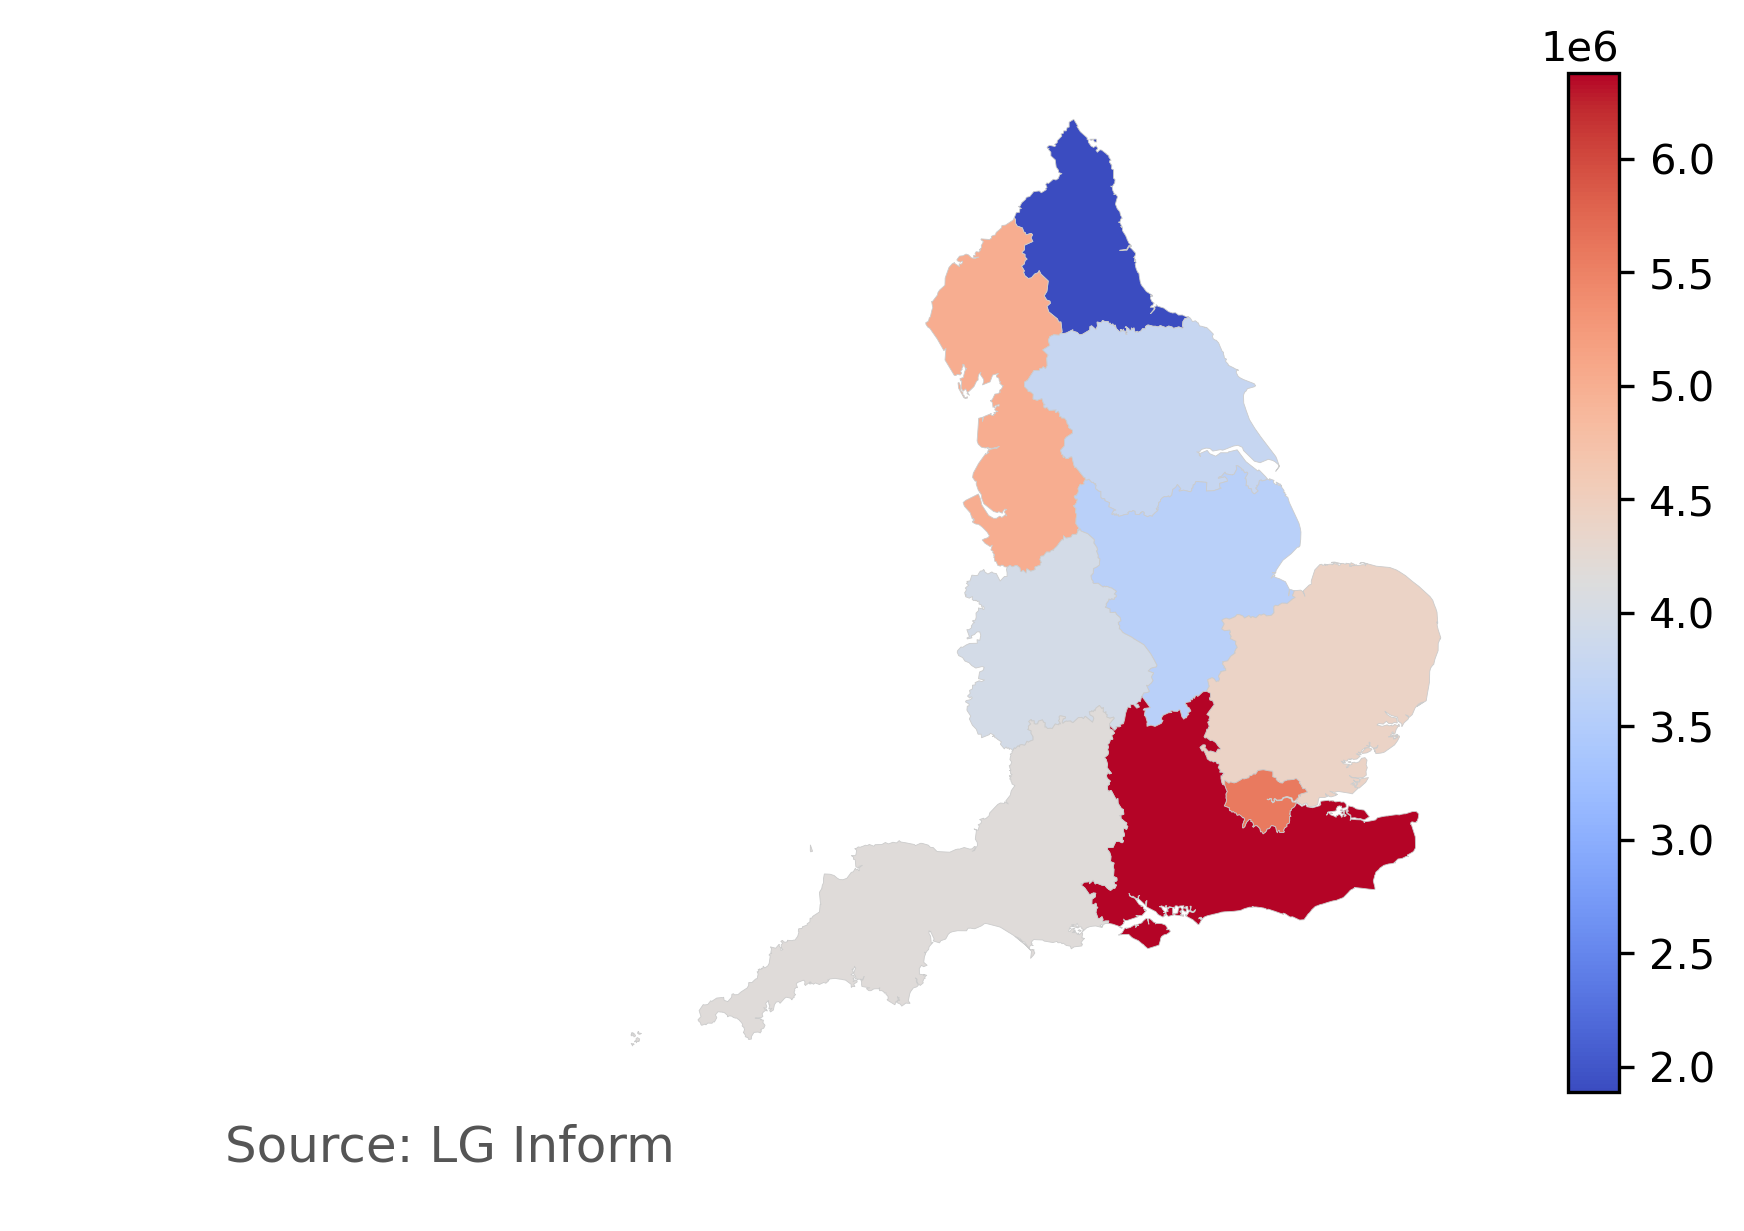

In [77]:
plotmap(variable='Cumulative 1st dose', df=merged, 
        title='Cumulative number of first doses per Region', output_file="dose1_map_region.png")

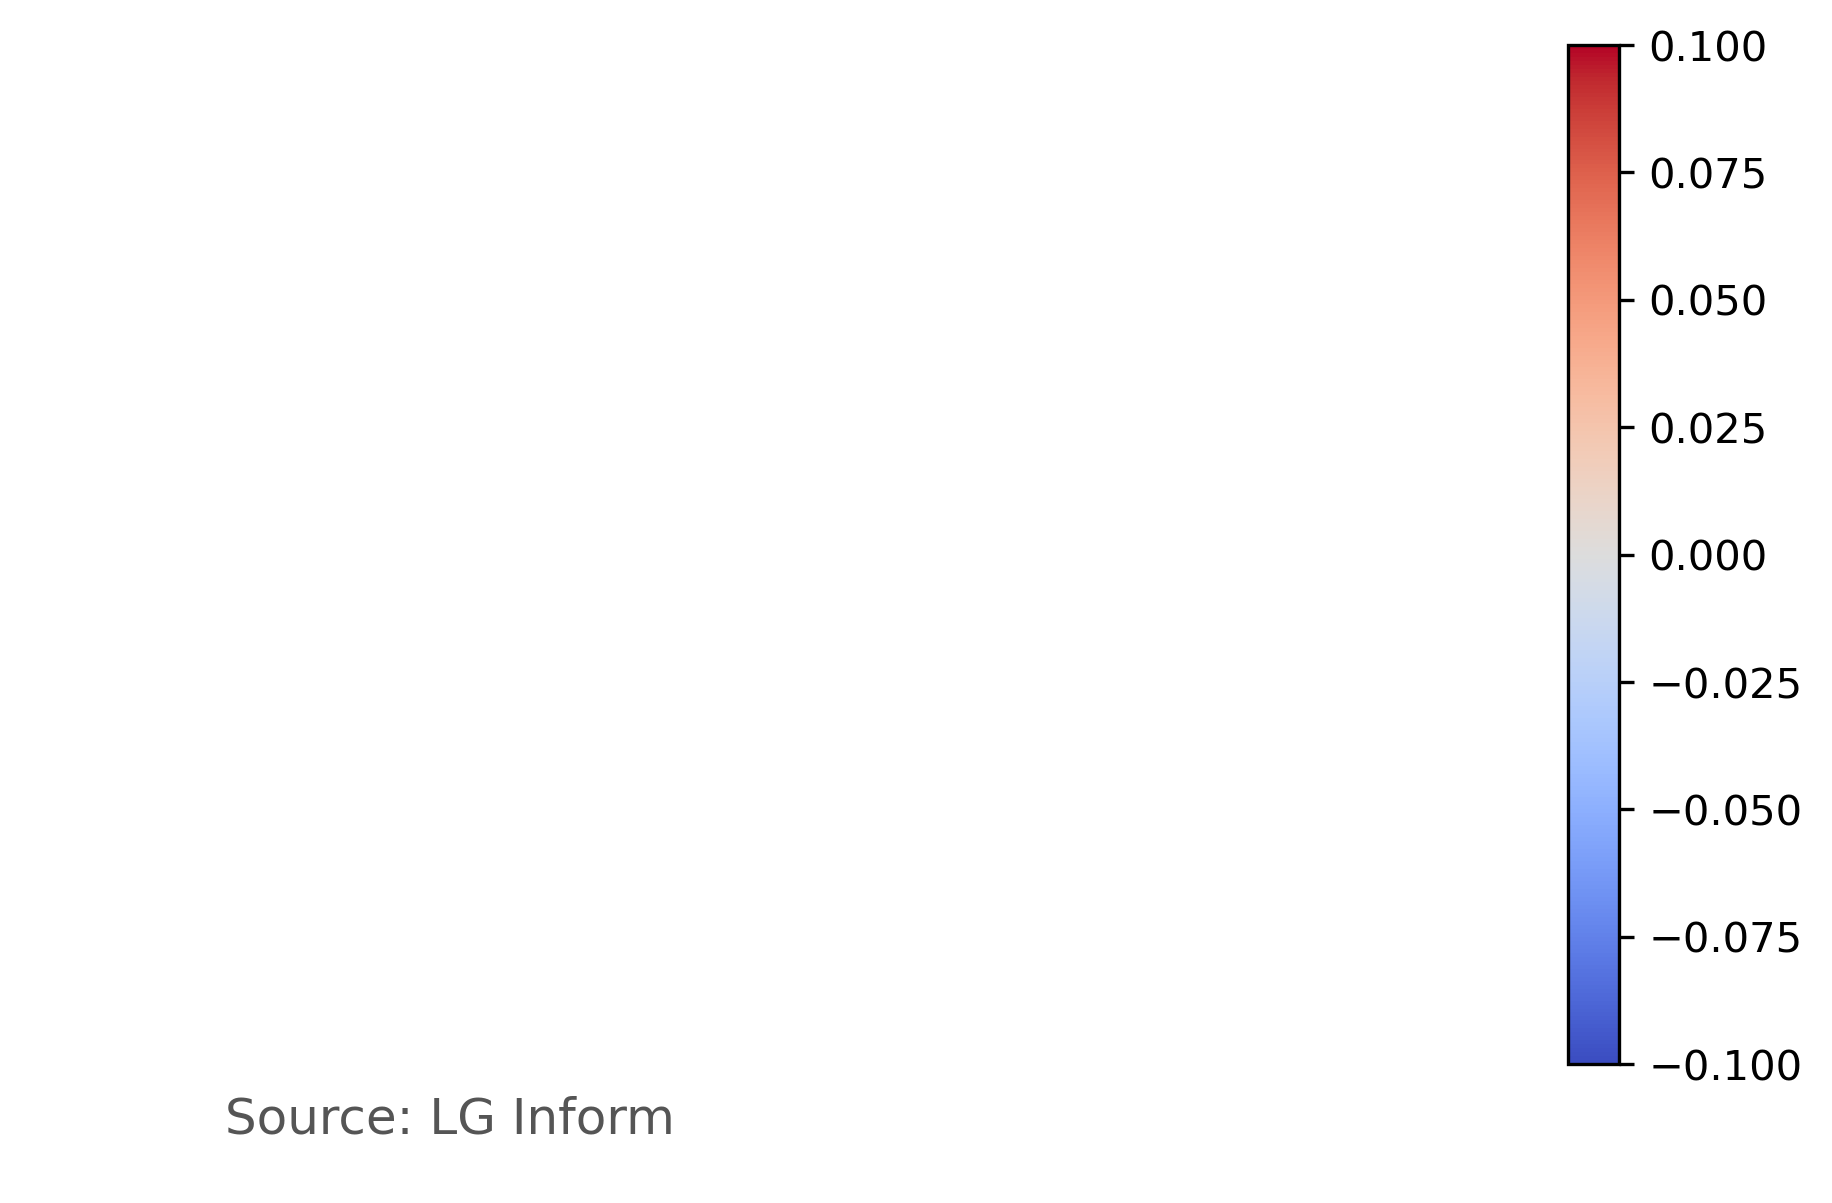

In [78]:
plotmap(variable='Cumulative 2nd dose', df=merged, 
        title='Cumulative number of second doses per Region', output_file="dose2_map_region.png")

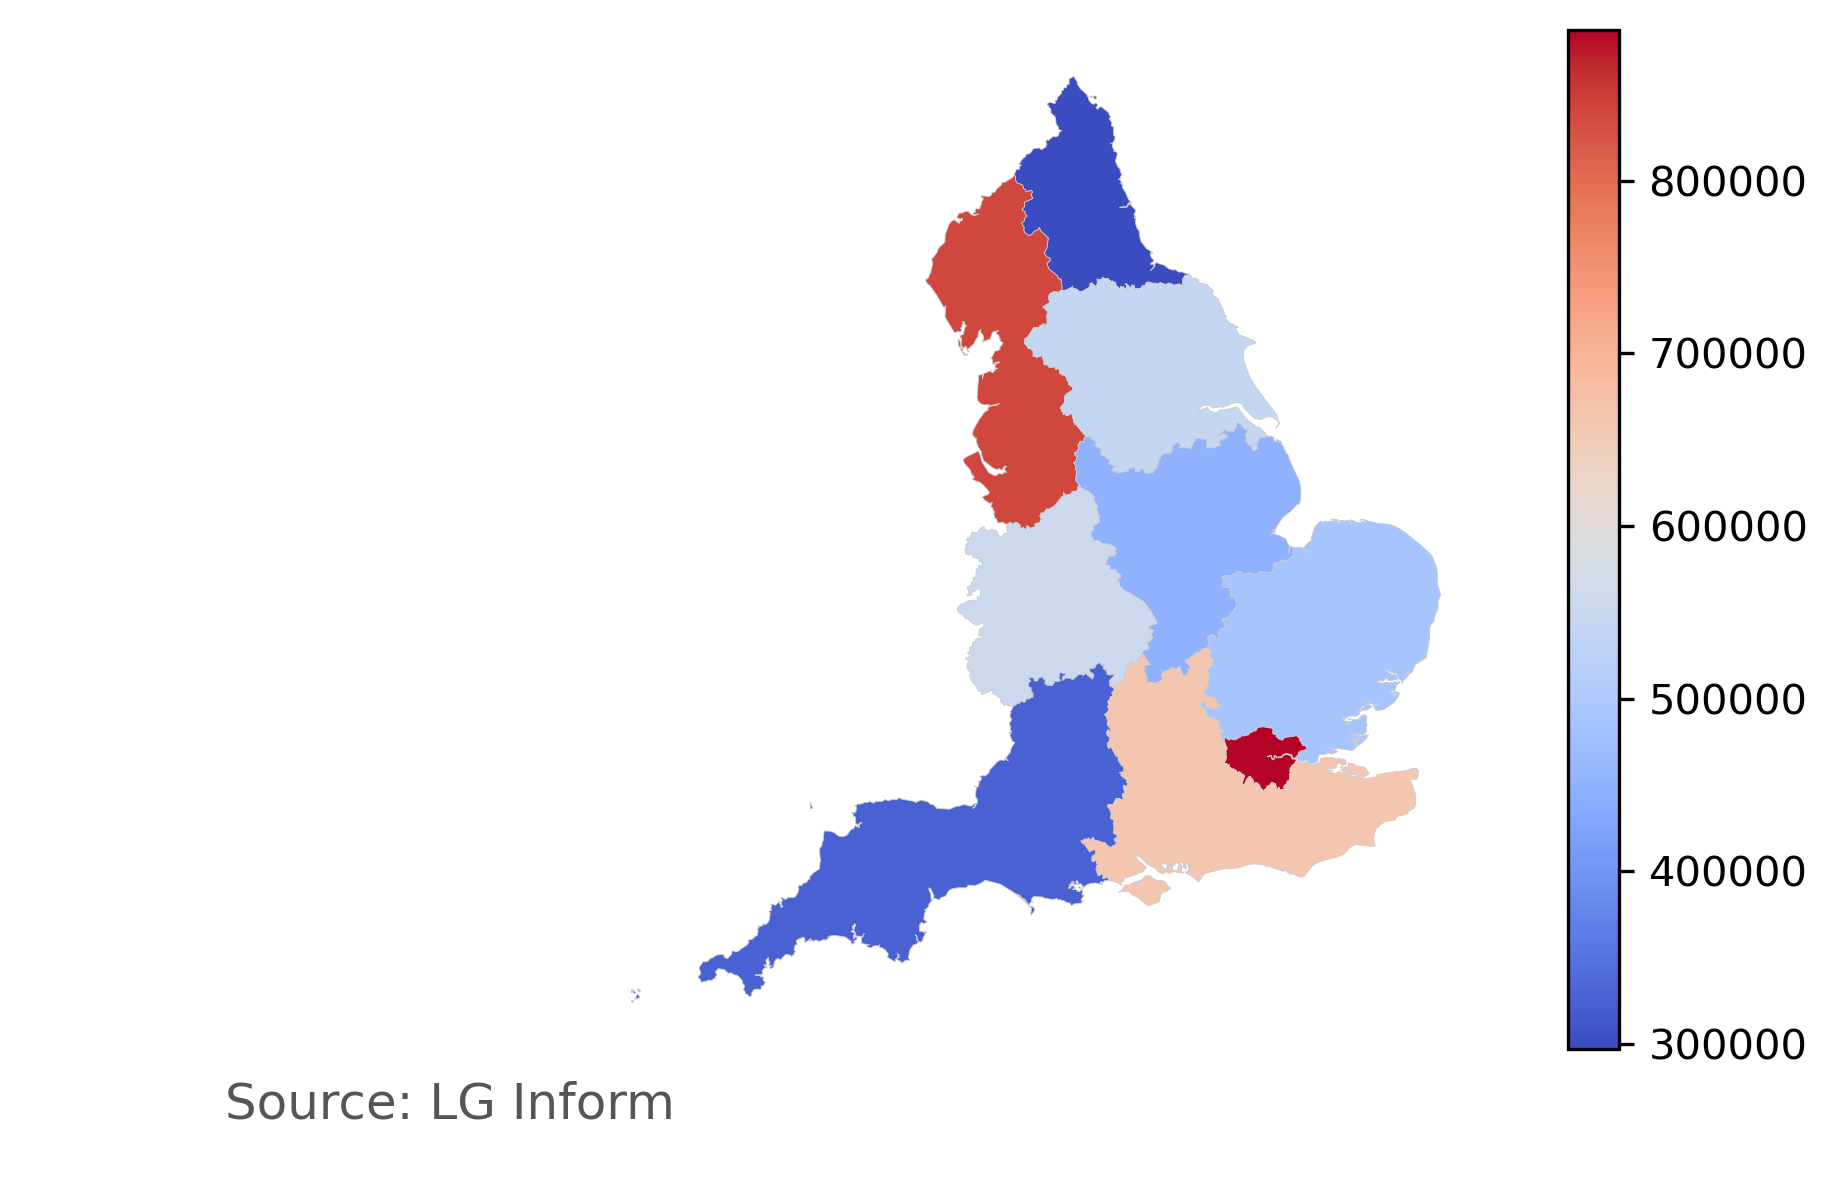

In [79]:
plotmap(variable='Cumulative confirmed cases', df=merged, 
        title='Cumulative number of confirmed cases per Region', output_file="cases_map_region.png")

##### Local Authorities

In [80]:
# set the filepath and load in a shapefile
fp = "./Local_Authority_Districts_(May_2021)_UK_BFE/Local_Authority_Districts_(May_2021)_UK_BFE.shp"
map_df = gpd.read_file(fp)

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df = map_df.copy()
map_df.head(2)

OBJECTID    LAD21CD        LAD21NM LAD21NMW   BNG_E   BNG_N     LONG  \
0         1  E06000001     Hartlepool     None  447160  531474 -1.27018   
1         2  E06000002  Middlesbrough     None  451141  516887 -1.21099   

        LAT    Shape__Are    Shape__Len  \
0  54.67614  9.835107e+07  66110.011028   
1  54.54467  5.455359e+07  41055.789790   

                                            geometry  
0  POLYGON ((447213.899 537036.104, 447228.798 53...  
1  POLYGON ((448489.897 522071.798, 448592.597 52...

In [81]:
map_df['LAD21NM'][map_df['LAD21NM'].str.contains('Bristol') == True]

22    Bristol, City of
Name: LAD21NM, dtype: object

In [82]:
map_df['LAD21NM'][map_df['LAD21NM'].str.contains('Bedford') == True]

51                 Bedford
52    Central Bedfordshire
Name: LAD21NM, dtype: object

In [83]:
map_df['LAD21NM'][map_df['LAD21NM'].str.contains('Durham') == True]

44    County Durham
Name: LAD21NM, dtype: object

In [84]:
map_df.loc[22,'LAD21NM'] = 'Bristol'
map_df.loc[51,'LAD21NM'] = 'Bedford Borough'
map_df.loc[44,'LAD21NM'] = 'Durham'

<AxesSubplot:>

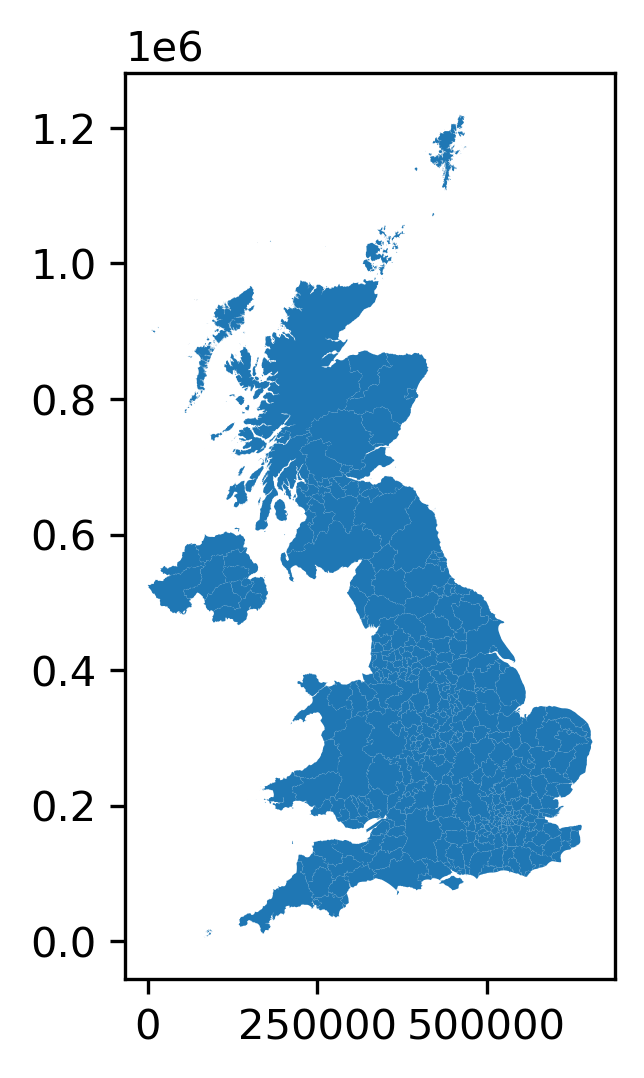

In [85]:
map_df.plot()

In [86]:
la_df[la_df['area label'].str.contains('Corn')].iloc[:,5:]

IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
84                                               0.61                  

    IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
84                                               3.37                                                      

    IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
84                                               6.75                       

    IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
84                                               3.37                                              

    IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
84                                               4.91                               

    IMD: Living Environment Deprivation - proportion of LSOAs in most deprived 10% nationally  \
84                                              48.16                                           

    Cumulative 1st dose  Cumulative 2nd dose  Total population  \
84             428387.0             372930.0          599785.0   

    Cumulative 1st dose per 100k  Cumulative 2nd dose per 100k  \
84                  71423.426728                  62177.280192   

    Cumulative confirmed cases per 100k  IMD: Overall - extent (%) per 100k  \
84                          3928.074227                            2.200789   

    Cumulative 1st dose by Cumulative 2nd dose  \
84                                    1.148706   

    Cumulative 1st dose by Cumulative confirmed cases  \
84                                           18.18281   

    IMD: Overall - extent (%) by Cumulative 1st dose  \
84                                          0.000031   

    Cumulative 2nd dose by Cumulative confirmed cases  \
84                                          15.828947   

    IMD: Overall - extent (%) by Cumulative 2nd dose  \
84                                          0.000035   

    IMD: Overall - extent (%) by Cumulative confirmed cases  
84                                            0.00056

In [87]:
# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index('LAD21NM').join(la_df.set_index('area label'))
merged.head(1)

OBJECTID    LAD21CD LAD21NMW   BNG_E   BNG_N     LONG       LAT  \
LAD21NM                                                                       
Hartlepool         1  E06000001     None  447160  531474 -1.27018  54.67614   

              Shape__Are    Shape__Len  \
LAD21NM                                  
Hartlepool  9.835107e+07  66110.011028   

                                                     geometry  ...  \
LAD21NM                                                        ...   
Hartlepool  POLYGON ((447213.899 537036.104, 447228.798 53...  ...   

           Cumulative 1st dose per 100k  Cumulative 2nd dose per 100k  \
LAD21NM                                                                 
Hartlepool                 65932.070236                  56002.775142   

            Cumulative confirmed cases per 100k  \
LAD21NM                                           
Hartlepool                         12797.281993   

            IMD: Overall - extent (%) per 100k  \
LAD21NM                                          
Hartlepool                           50.707559   

            Cumulative 1st dose by Cumulative 2nd dose  \
LAD21NM                                                  
Hartlepool                                      1.1773   

            Cumulative 1st dose by Cumulative confirmed cases  \
LAD21NM                                                         
Hartlepool                                           5.152037   

            IMD: Overall - extent (%) by Cumulative 1st dose  \
LAD21NM                                                        
Hartlepool                                          0.000769   

            Cumulative 2nd dose by Cumulative confirmed cases  \
LAD21NM                                                         
Hartlepool                                           4.376146   

            IMD: Overall - extent (%) by Cumulative 2nd dose  \
LAD21NM                                                        
Hartlepool                                          0.000905   

            IMD: Overall - extent (%) by Cumulative confirmed cases  
LAD21NM                                                              
Hartlepool                                           0.003962        

[1 rows x 33 columns]

In [88]:
merged = merged.drop(['LAD21NMW'],axis=1)
merged['Cumulative 1st dose'] = pd.to_numeric(merged['Cumulative 1st dose'], errors='coerce')
merged['Cumulative 2nd dose'] = pd.to_numeric(merged['Cumulative 2nd dose'], errors='coerce')
merged['Cumulative confirmed cases'] = pd.to_numeric(merged['Cumulative confirmed cases'], errors='coerce')
merged['IMD: Overall - extent (%)'] = pd.to_numeric(merged['IMD: Overall - extent (%)'], errors='coerce')

In [89]:
map_df[map_df['LAD21NM']=='North Northamptonshire']

OBJECTID    LAD21CD                 LAD21NM LAD21NMW   BNG_E   BNG_N  \
57        58  E06000061  North Northamptonshire     None  493590  281718   

       LONG       LAT    Shape__Are     Shape__Len  \
57 -0.62504  52.42546  9.865946e+08  210629.486174   

                                             geometry  
57  POLYGON ((500812.799 306101.699, 500815.800 30...

In [90]:
imd_la_df = pd.concat([imd_la_df.iloc[:,0:2],imd_la_df.iloc[:,2::3]],axis=1)

In [91]:
imd_la_df = imd_la_df[~imd_la_df['area'].astype(str).str.startswith('S')]
imd_la_df = imd_la_df[~imd_la_df['area'].astype(str).str.startswith('W')]
imd_la_df = imd_la_df[~imd_la_df['area'].astype(str).str.startswith('N')]
imd_la_df.head(3)

area label       area IMD: Overall - extent (%)  \
7          Adur  E07000223                      7.90   
8     Allerdale  E07000026                     19.90   
9  Amber Valley  E07000032                     11.00   

  IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally  \
7                                               0.00                                            
8                                              13.33                                            
9                                               2.56                                            

  IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
7                                               0.00                 
8                                               0.00                 
9                                               0.00                 

  IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
7                                               7.14                                                     
8                                              18.33                                                     
9                                              11.54                                                     

  IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
7                                               0.00                      
8                                              13.33                      
9                                               3.85                      

  IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
7                                               0.00                                             
8                                              11.67                                             
9                                               5.13                                             

  IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
7                                               0.00                              
8                                              10.00                              
9                                               3.85                              

  IMD: Living Environment Deprivation - proportion of LSOAs in most deprived 10% nationally  
7                                               0.00                                         
8                                              21.67                                         
9                                               3.85

In [92]:
imd_la_df[imd_la_df['IMD: Overall - extent (%)']=='no value']

area label       area IMD: Overall - extent (%)  \
53          Buckinghamshire  E06000060                  no value   
245  North Northamptonshire  E06000061                  no value   
382   West Northamptonshire  E06000062                  no value   

    IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally  \
53                                               11.60                                            
245                                               6.19                                            
382                                               7.02                                            

    IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
53                                                0.31                 
245                                               5.67                 
382                                              12.72                 

    IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
53                                                2.51                                                     
245                                              14.95                                                     
382                                               7.46                                                     

    IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
53                                                0.00                      
245                                               5.67                      
382                                               3.51                      

    IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
53                                                0.00                                             
245                                               7.22                                             
382                                               5.26                                             

    IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
53                                                0.00                              
245                                               5.67                              
382                                               3.95                              

    IMD: Living Environment Deprivation - proportion of LSOAs in most deprived 10% nationally  
53                                                0.94                                         
245                                               1.03                                         
382                                               3.51

In [93]:
la_df[la_df['area label']=='Buckinghamshire']

area label  area code  Cumulative confirmed cases  \
53  Buckinghamshire  E06000060                     40769.0   

    IMD: Overall - extent (%)  \
53                        0.0   

    IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally  \
53                                               11.6                                             

    IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
53                                               0.31                  

    IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
53                                               2.51                                                      

    IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
53                                                0.0                       

    IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
53                                                0.0                                              

    IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
53                                                0.0                               

    ...  Cumulative 1st dose per 100k  Cumulative 2nd dose per 100k  \
53  ...                  66909.873668                  57616.617016   

    Cumulative confirmed cases per 100k  IMD: Overall - extent (%) per 100k  \
53                          6976.059739                                 0.0   

    Cumulative 1st dose by Cumulative 2nd dose  \
53                                    1.161295   

    Cumulative 1st dose by Cumulative confirmed cases  \
53                                           9.591356   

    IMD: Overall - extent (%) by Cumulative 1st dose  \
53                                               0.0   

    Cumulative 2nd dose by Cumulative confirmed cases  \
53                                           8.259192   

    IMD: Overall - extent (%) by Cumulative 2nd dose  \
53                                               0.0   

    IMD: Overall - extent (%) by Cumulative confirmed cases  
53                                                0.0        

[1 rows x 24 columns]

In [94]:
map_df[map_df['LAD21NM']=='Buckinghamshire']

OBJECTID    LAD21CD          LAD21NM LAD21NMW   BNG_E   BNG_N     LONG  \
56        57  E06000060  Buckinghamshire     None  482506  208561 -0.80569   

         LAT    Shape__Are     Shape__Len  \
56  51.76966  1.564949e+09  361852.640717   

                                             geometry  
56  POLYGON ((472045.402 242897.101, 472047.999 24...

In [95]:
la_df[la_df['area label']=='North Northamptonshire']

area label  area code  Cumulative confirmed cases  \
245  North Northamptonshire  E06000061                     27015.0   

     IMD: Overall - extent (%)  \
245                   5.670103   

     IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally  \
245                                               6.19                                             

     IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
245                                               5.67                  

     IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
245                                              14.95                                                      

     IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
245                                               5.67                       

     IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
245                                               7.22                                              

     IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
245                                               5.67                               

     ...  Cumulative 1st dose per 100k  Cumulative 2nd dose per 100k  \
245  ...                  63255.877407                  54118.579191   

     Cumulative confirmed cases per 100k  IMD: Overall - extent (%) per 100k  \
245                          7087.518988                             1.48758   

     Cumulative 1st dose by Cumulative 2nd dose  \
245                                    1.168838   

     Cumulative 1st dose by Cumulative confirmed cases  \
245                                           8.924968   

     IMD: Overall - extent (%) by Cumulative 1st dose  \
245                                          0.000024   

     Cumulative 2nd dose by Cumulative confirmed cases  \
245                                           7.635758   

     IMD: Overall - extent (%) by Cumulative 2nd dose  \
245                                          0.000027   

     IMD: Overall - extent (%) by Cumulative confirmed cases  
245                                            0.00021        

[1 rows x 24 columns]

In [96]:
merged = merged[~merged['LAD21CD'].astype(str).str.startswith('S')]
merged = merged[~merged['LAD21CD'].astype(str).str.startswith('W')]
merged = merged[~merged['LAD21CD'].astype(str).str.startswith('N')]
merged

OBJECTID    LAD21CD   BNG_E   BNG_N     LONG       LAT  \
LAD21NM                                                                        
Hartlepool                   1  E06000001  447160  531474 -1.27018  54.67614   
Middlesbrough                2  E06000002  451141  516887 -1.21099  54.54467   
Redcar and Cleveland         3  E06000003  464361  519597 -1.00608  54.56752   
Stockton-on-Tees             4  E06000004  444940  518183 -1.30664  54.55691   
Darlington                   5  E06000005  428029  515648 -1.56835  54.53534   
...                        ...        ...     ...     ...      ...       ...   
Sutton                     305  E09000029  527357  163639 -0.17226  51.35755   
Tower Hamlets              306  E09000030  536340  181452 -0.03647  51.51554   
Waltham Forest             307  E09000031  537328  190278 -0.01880  51.59461   
Wandsworth                 308  E09000032  525152  174138 -0.20021  51.45240   
Westminster                309  E09000033  528268  180871 -0.15295  51.51221   

                        Shape__Are     Shape__Len  \
LAD21NM                                             
Hartlepool            9.835107e+07   66110.011028   
Middlesbrough         5.455359e+07   41055.789790   
Redcar and Cleveland  2.537854e+08  105292.103526   
Stockton-on-Tees      2.097308e+08  108085.190140   
Darlington            1.974778e+08  107203.152334   
...                            ...            ...   
Sutton                4.384769e+07   39927.915712   
Tower Hamlets         2.157691e+07   26818.136105   
Waltham Forest        3.881023e+07   33346.575271   
Wandsworth            3.521603e+07   37444.099887   
Westminster           2.203779e+07   27258.578951   

                                                               geometry  \
LAD21NM                                                                   
Hartlepool            POLYGON ((447213.899 537036.104, 447228.798 53...   
Middlesbrough         POLYGON ((448489.897 522071.798, 448592.597 52...   
Redcar and Cleveland  POLYGON ((455525.931 528406.654, 455724.632 52...   
Stockton-on-Tees      POLYGON ((444157.002 527956.304, 444165.898 52...   
Darlington            POLYGON ((423496.602 524724.299, 423497.204 52...   
...                                                                 ...   
Sutton                POLYGON ((527085.942 167617.691, 527087.728 16...   
Tower Hamlets         POLYGON ((536776.386 184446.881, 536777.600 18...   
Waltham Forest        POLYGON ((537921.098 196048.201, 537947.499 19...   
Wandsworth            POLYGON ((530059.620 177871.478, 530066.940 17...   
Westminster           POLYGON ((526755.127 183684.425, 526773.270 18...   

                      area code  ...  Cumulative 1st dose per 100k  \
LAD21NM                          ...                                 
Hartlepool            E06000001  ...                  65932.070236   
Middlesbrough         E06000002  ...                  59079.960122   
Redcar and Cleveland  E06000003  ...                  69790.695228   
Stockton-on-Tees      E06000004  ...                  66824.074164   
Darlington            E06000005  ...                  68039.021309   
...                         ...  ...                           ...   
Sutton                E09000029  ...                  62033.340431   
Tower Hamlets         E09000030  ...                  52006.264667   
Waltham Forest        E09000031  ...                  49924.256770   
Wandsworth            E09000032  ...                  55451.154818   
Westminster           E09000033  ...                  49643.629970   

                      Cumulative 2nd dose per 100k  \
LAD21NM                                              
Hartlepool                            56002.775142   
Middlesbrough                         48944.536296   
Redcar and Cleveland                  60734.144375   
Stockton-on-Tees                      56724.216265   
Darlington                            57672.231531   
...                       

In [97]:
merged.to_file('output_test.shp')  

C:\Users\joshb\AppData\Local\Temp/ipykernel_7276/505865104.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged.to_file('output_test.shp')


In [98]:
merged[merged['Cumulative 1st dose'].isna()].index

Index(['Kingston upon Hull, City of', 'Herefordshire, County of',
       'Isles of Scilly', 'City of London', 'Hackney'],
      dtype='object', name='LAD21NM')

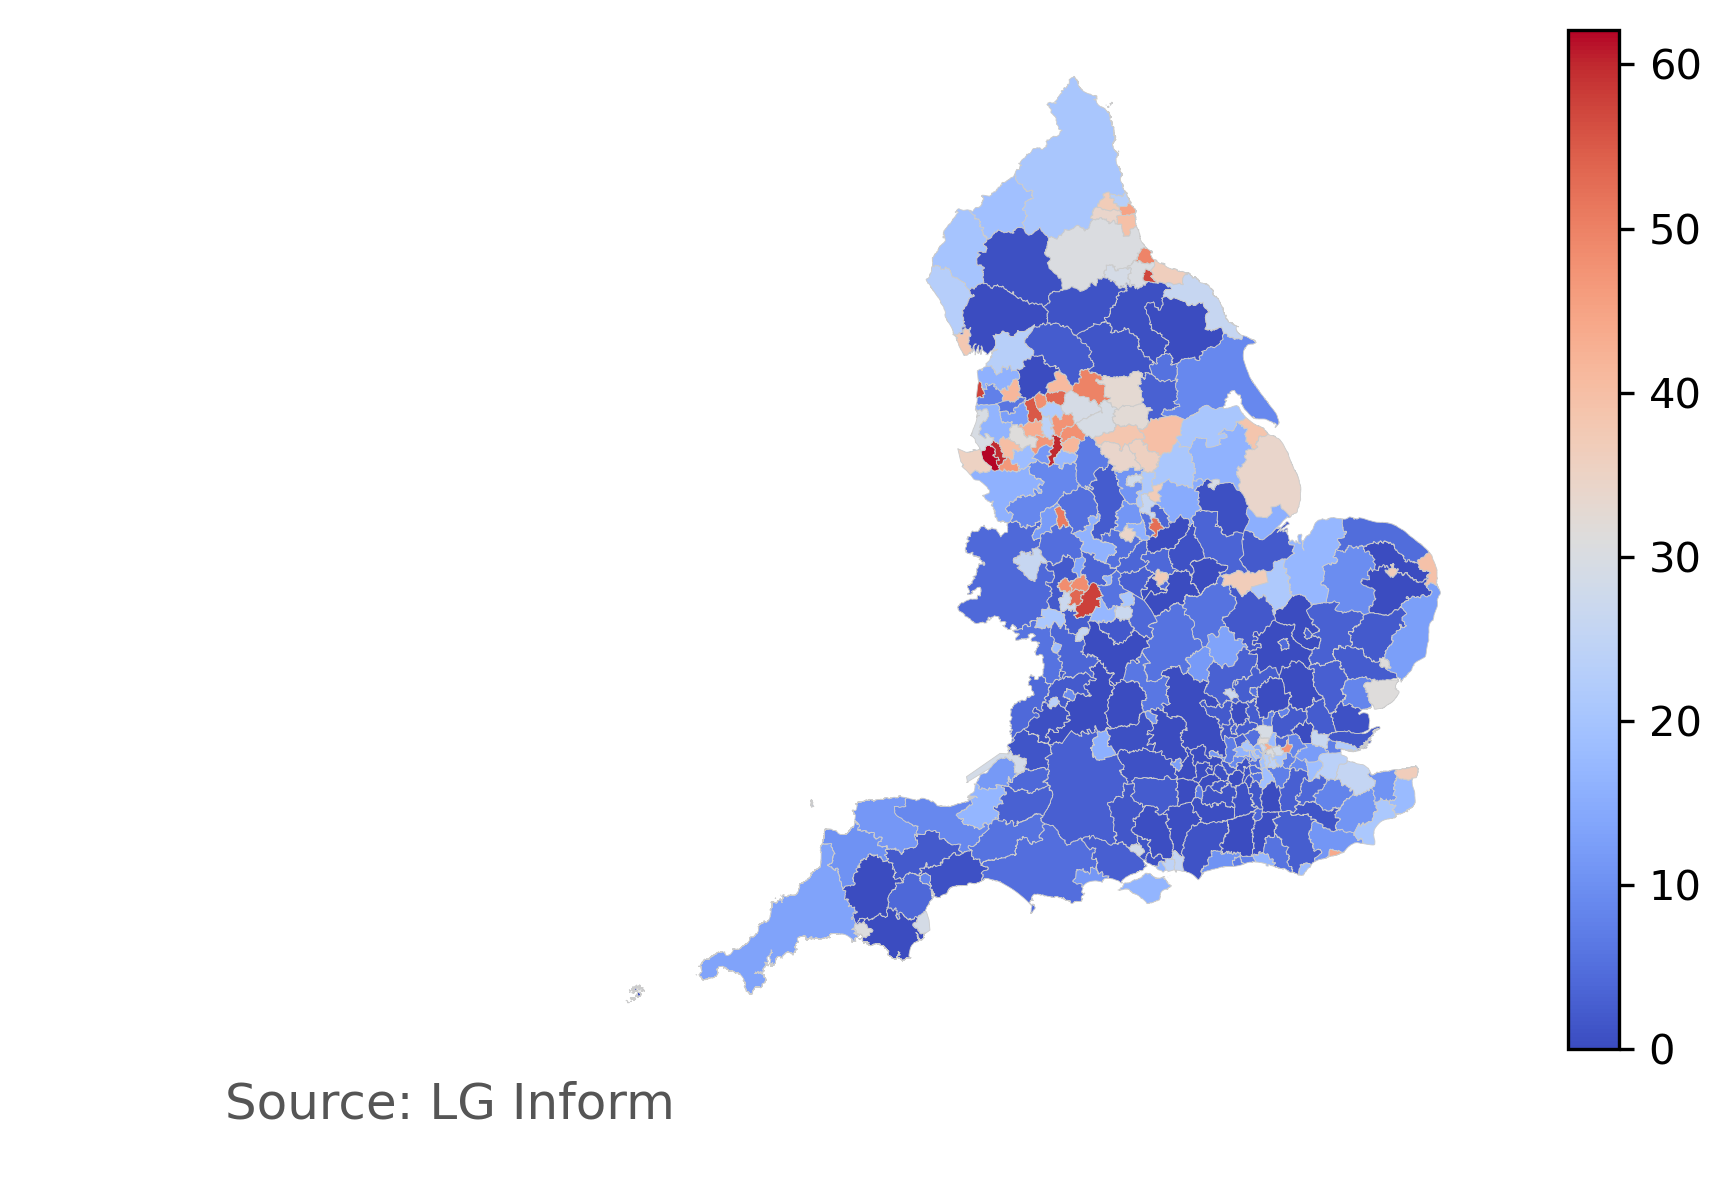

In [99]:
plotmap(variable='IMD: Overall - extent (%)', df=merged, 
        title='IMD: Overall - extent (%) per Local Authority', output_file="IMD_map_la.png")

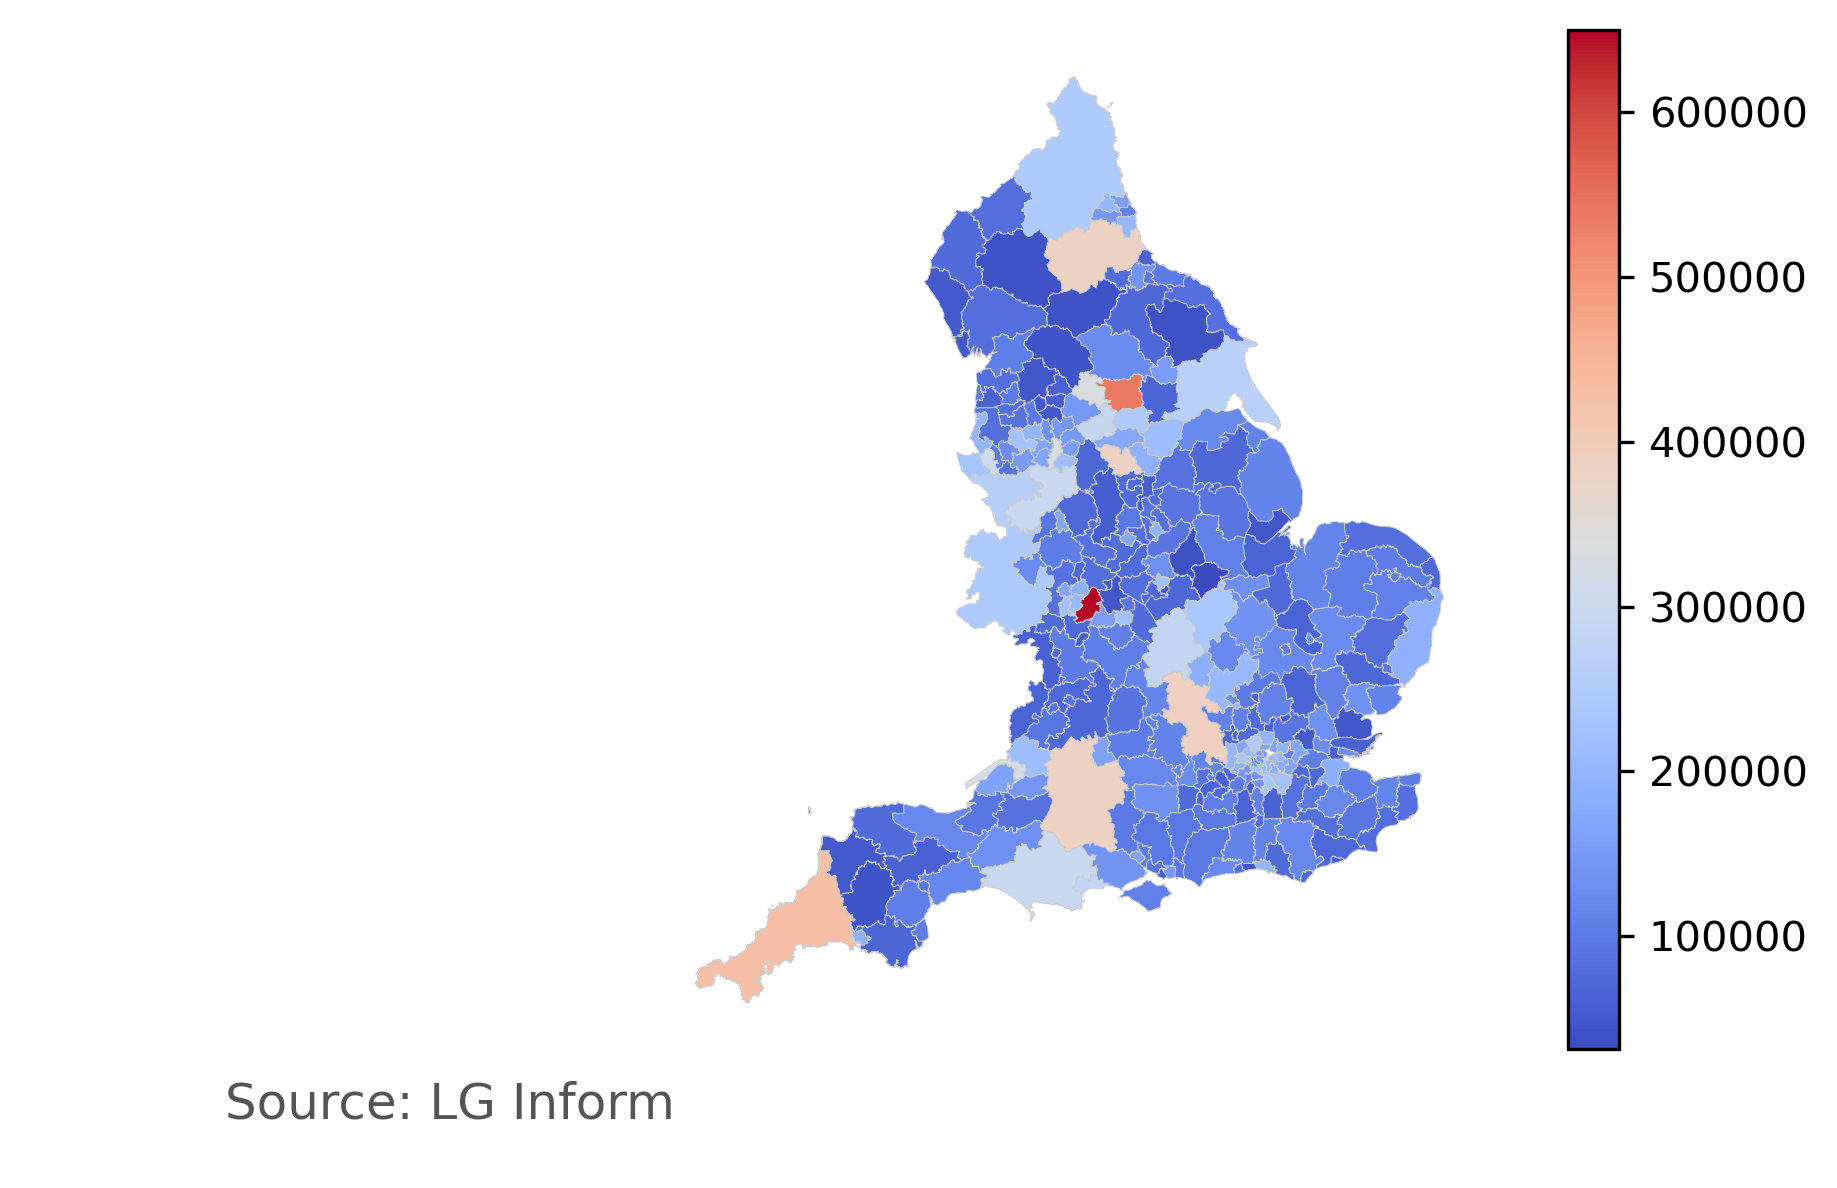

In [100]:
plotmap(variable='Cumulative 1st dose', df=merged, 
        title='Cumulative number of first doses per Local Authority', output_file="dose1_map_la.png")

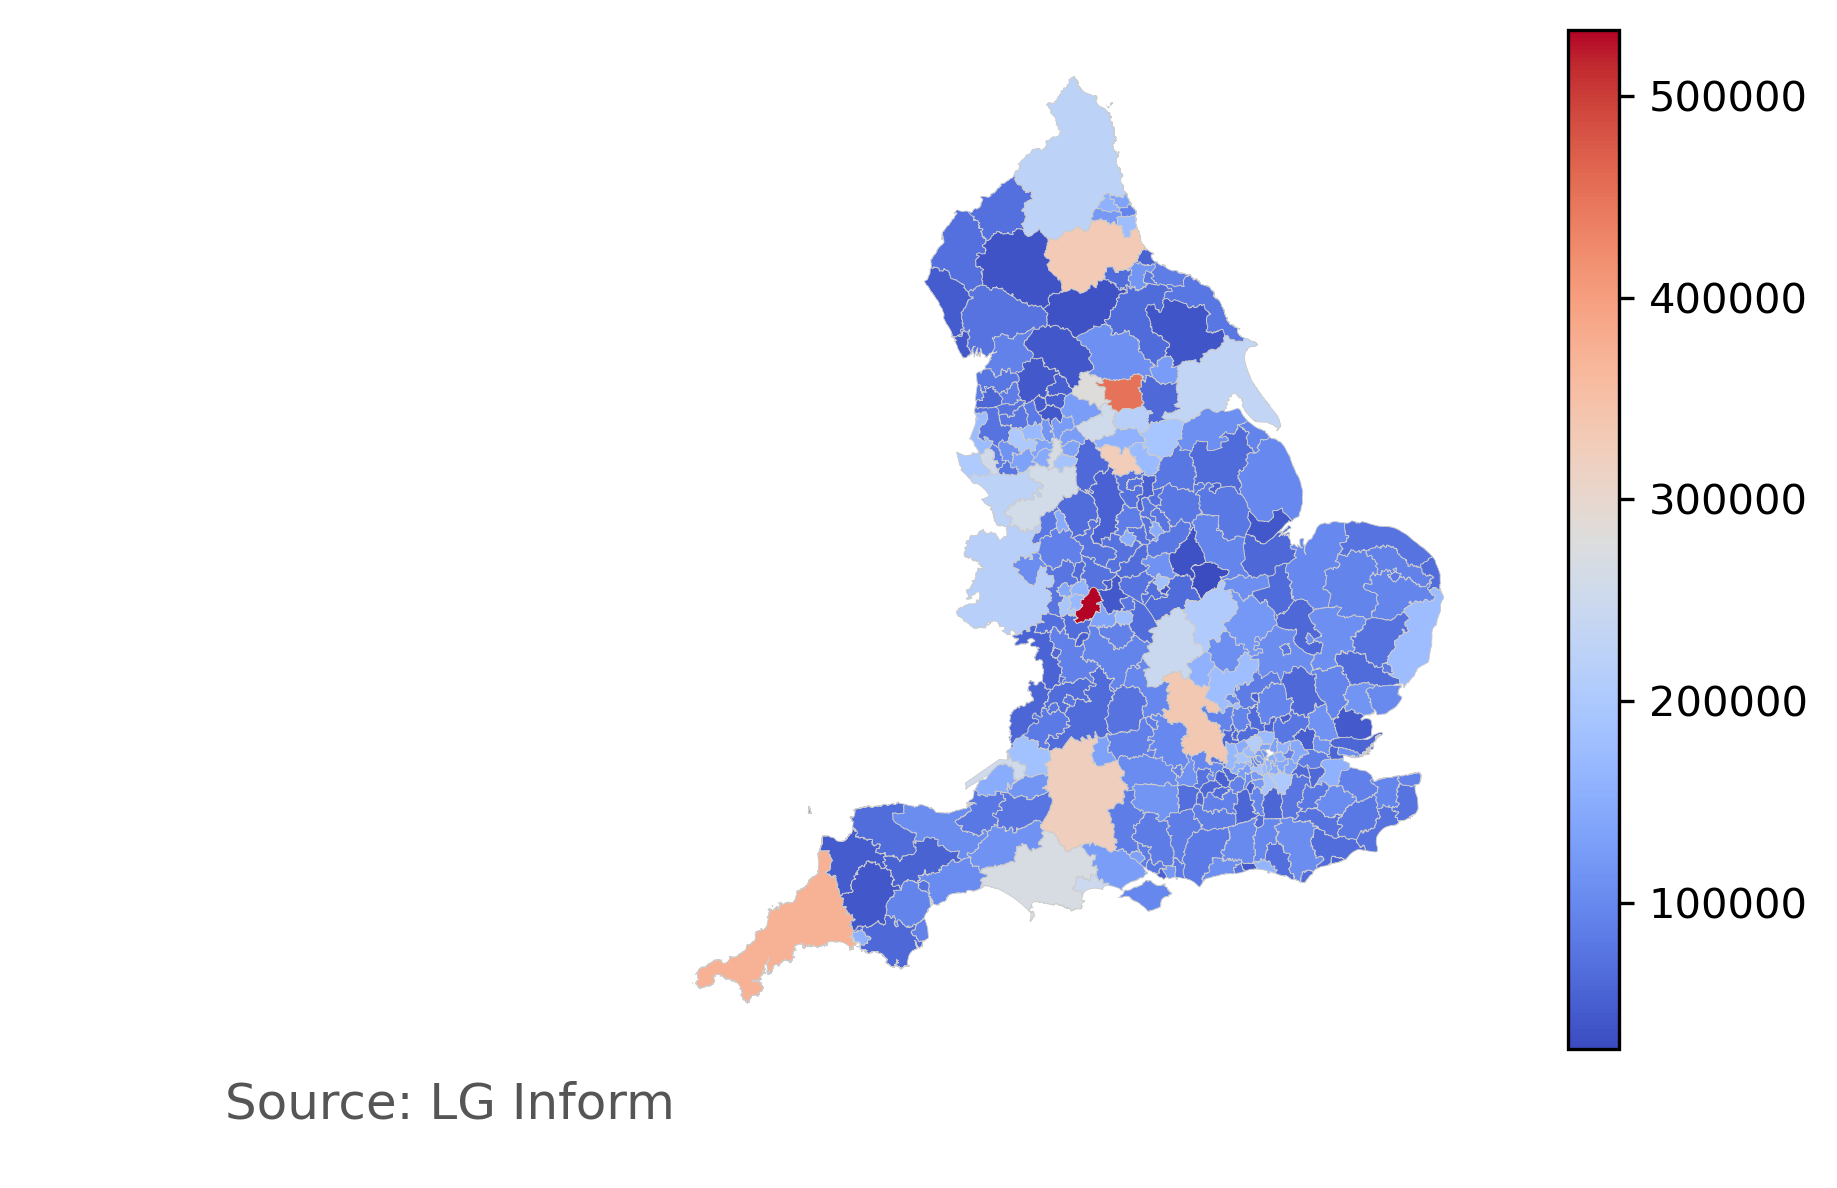

In [101]:
plotmap(variable='Cumulative 2nd dose', df=merged, 
        title='Cumulative number of second doses per Local Authority', output_file="dose2_map_la.png")

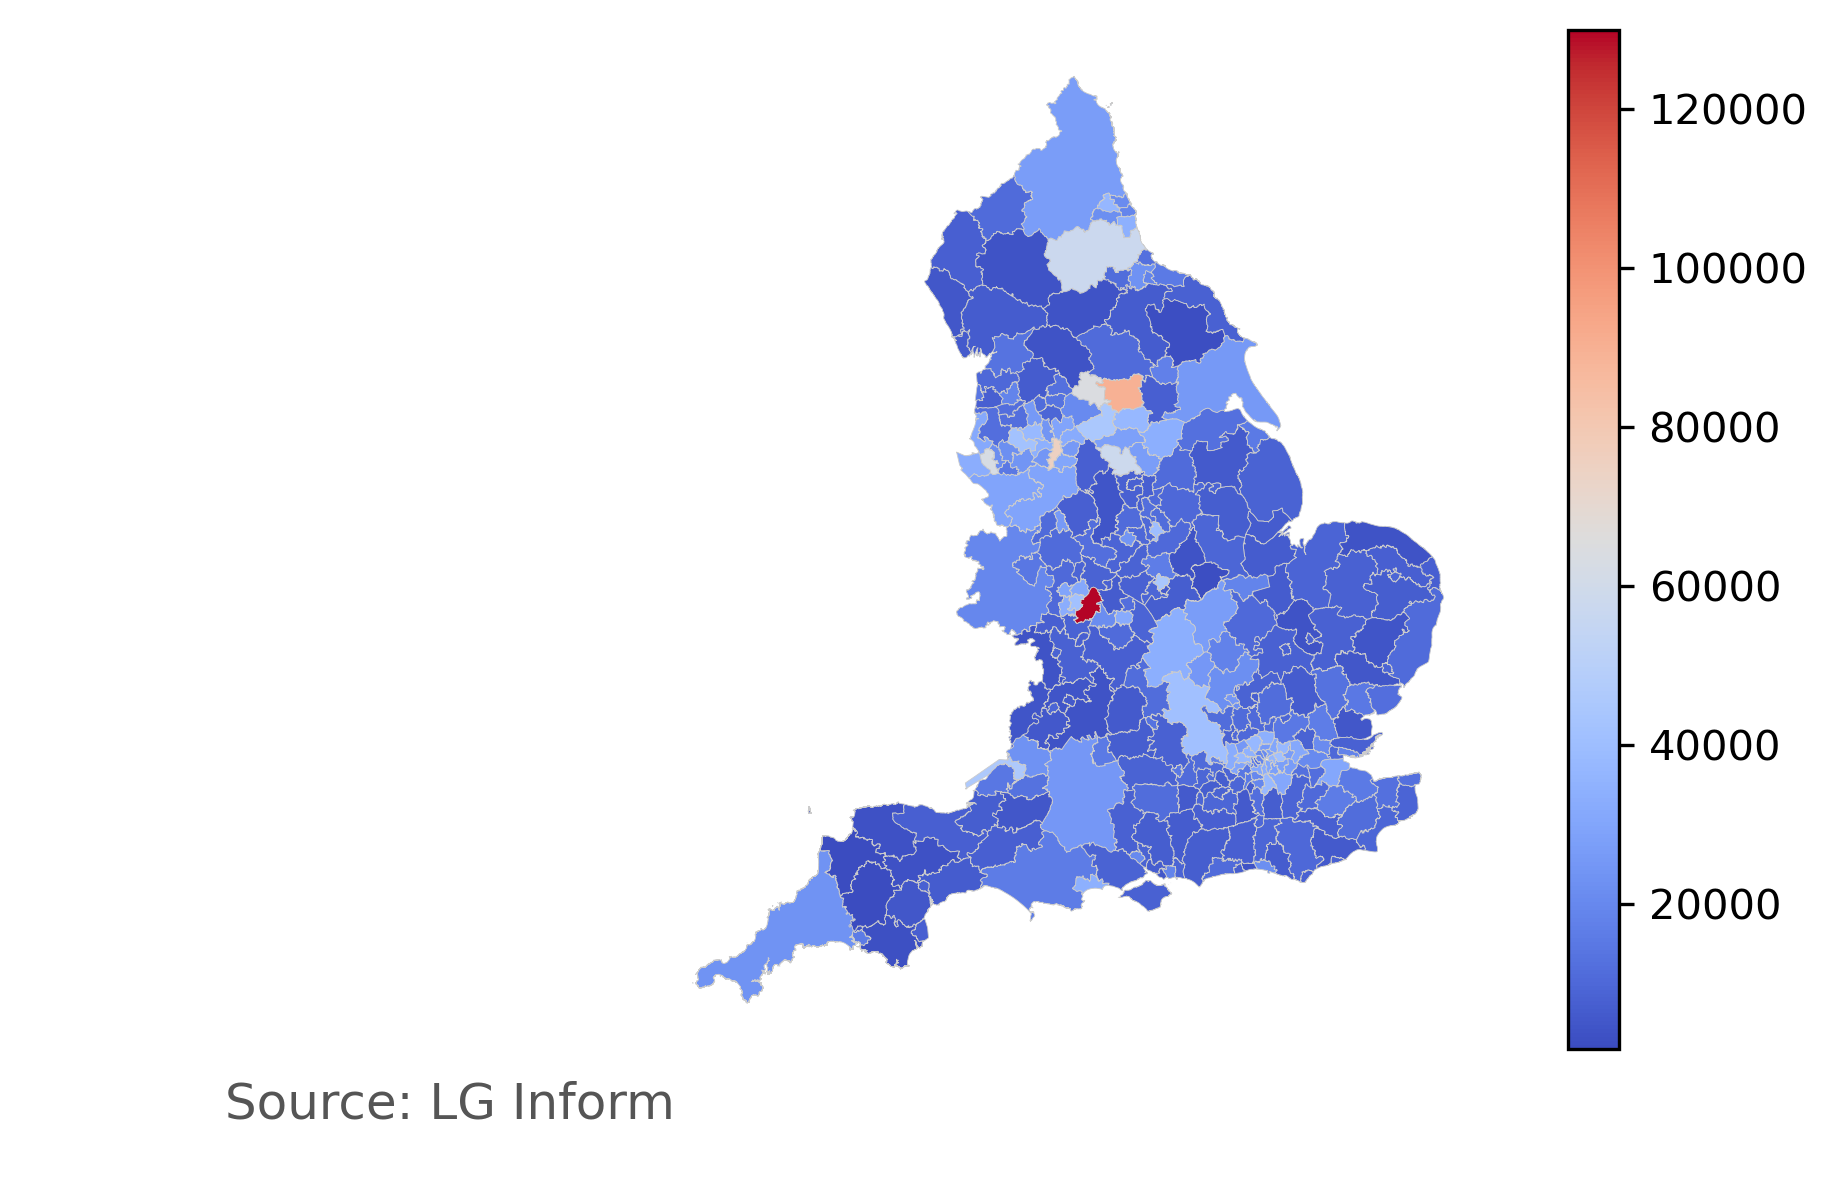

In [102]:
plotmap(variable='Cumulative confirmed cases', df=merged, 
        title='Cumulative number of confirmed cases per Local Authority', output_file="cases_map_la.png")

In [103]:
merged[merged['Cumulative confirmed cases per 100k'].isna()].iloc[:,11:]

IMD: Overall - extent (%)  \
LAD21NM                                                  
Kingston upon Hull, City of                        NaN   
Herefordshire, County of                           NaN   
Isles of Scilly                                    0.0   
City of London                                     3.2   

                             IMD: Barriers to Housing and Services - proportion of LSOAs in most deprived 10% nationally  \
LAD21NM                                                                                                                    
Kingston upon Hull, City of                                                NaN                                             
Herefordshire, County of                                                   NaN                                             
Isles of Scilly                                                           0.00                                             
City of London                                                           66.67                                             

                             IMD: Crime - proportion of LSOAs in most deprived 10% nationally  \
LAD21NM                                                                                         
Kingston upon Hull, City of                                                NaN                  
Herefordshire, County of                                                   NaN                  
Isles of Scilly                                                            0.0                  
City of London                                                             0.0                  

                             IMD: Education Skills and Training Deprivation - proportion of LSOAs in most deprived 10% nationally  \
LAD21NM                                                                                                                             
Kingston upon Hull, City of                                                NaN                                                      
Herefordshire, County of                                                   NaN                                                      
Isles of Scilly                                                            0.0                                                      
City of London                                                             0.0                                                      

                             IMD: Employment - proportion of LSOAs in most deprived 10% nationally  \
LAD21NM                                                                                              
Kingston upon Hull, City of                                                NaN                       
Herefordshire, County of                                                   NaN                       
Isles of Scilly                                                            0.0                       
City of London                                                             0.0                       

                             IMD: Health Deprivation and Disability - proportion of LSOAs in most deprived 10% nationally  \
LAD21NM                                                                                                                     
Kingston upon Hull, City of                                                NaN                                              
Herefordshire, County of                                                   NaN                                              
Isles of Scilly                                                            0.0                                              
City of London                                                             0.0                                              

                             IMD: Income Deprivation - proportion of LSOAs in most deprived 10% nationally  \
LAD21NM                                                                        

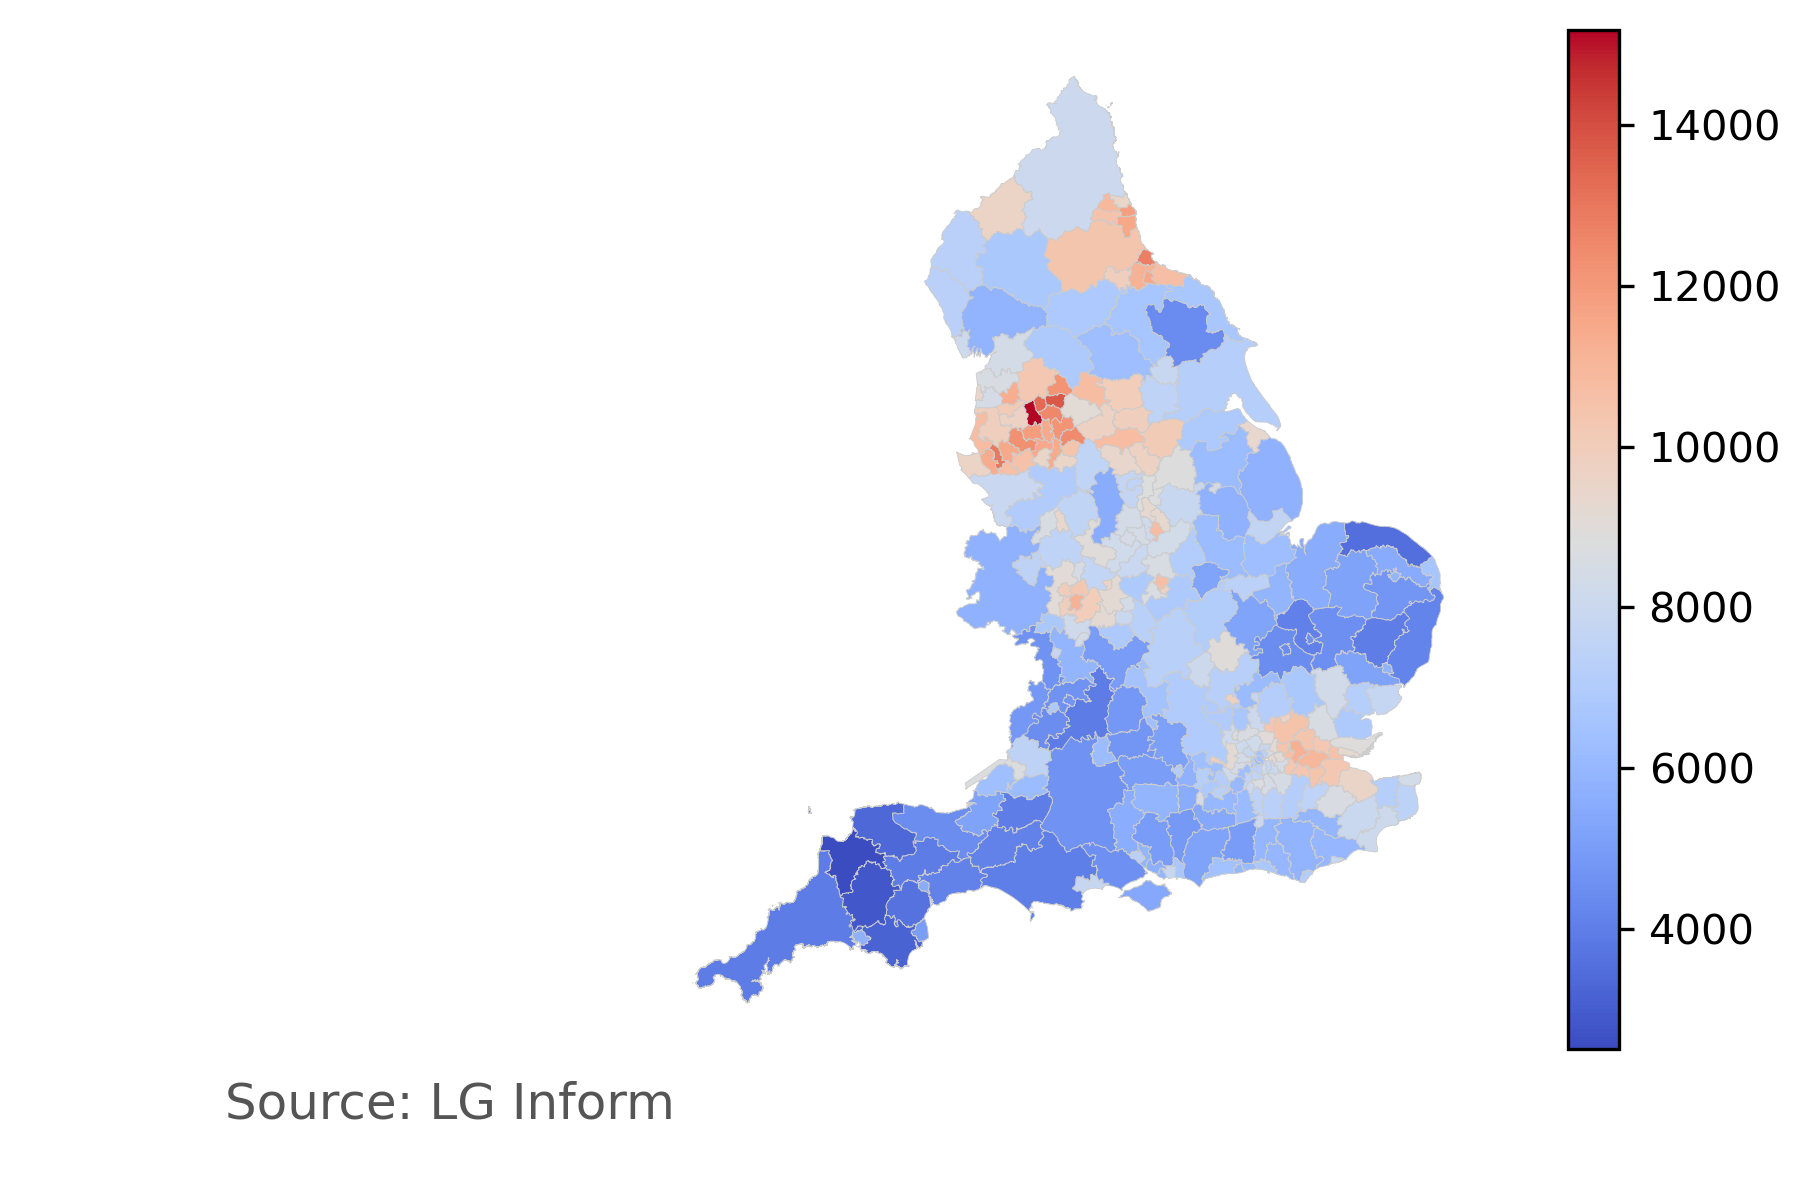

In [104]:
plotmap(variable='Cumulative confirmed cases per 100k', df=merged, 
        title='Cumulative confirmed cases per 100k per Local Authority', output_file="cases_per_100k_map_la.png")

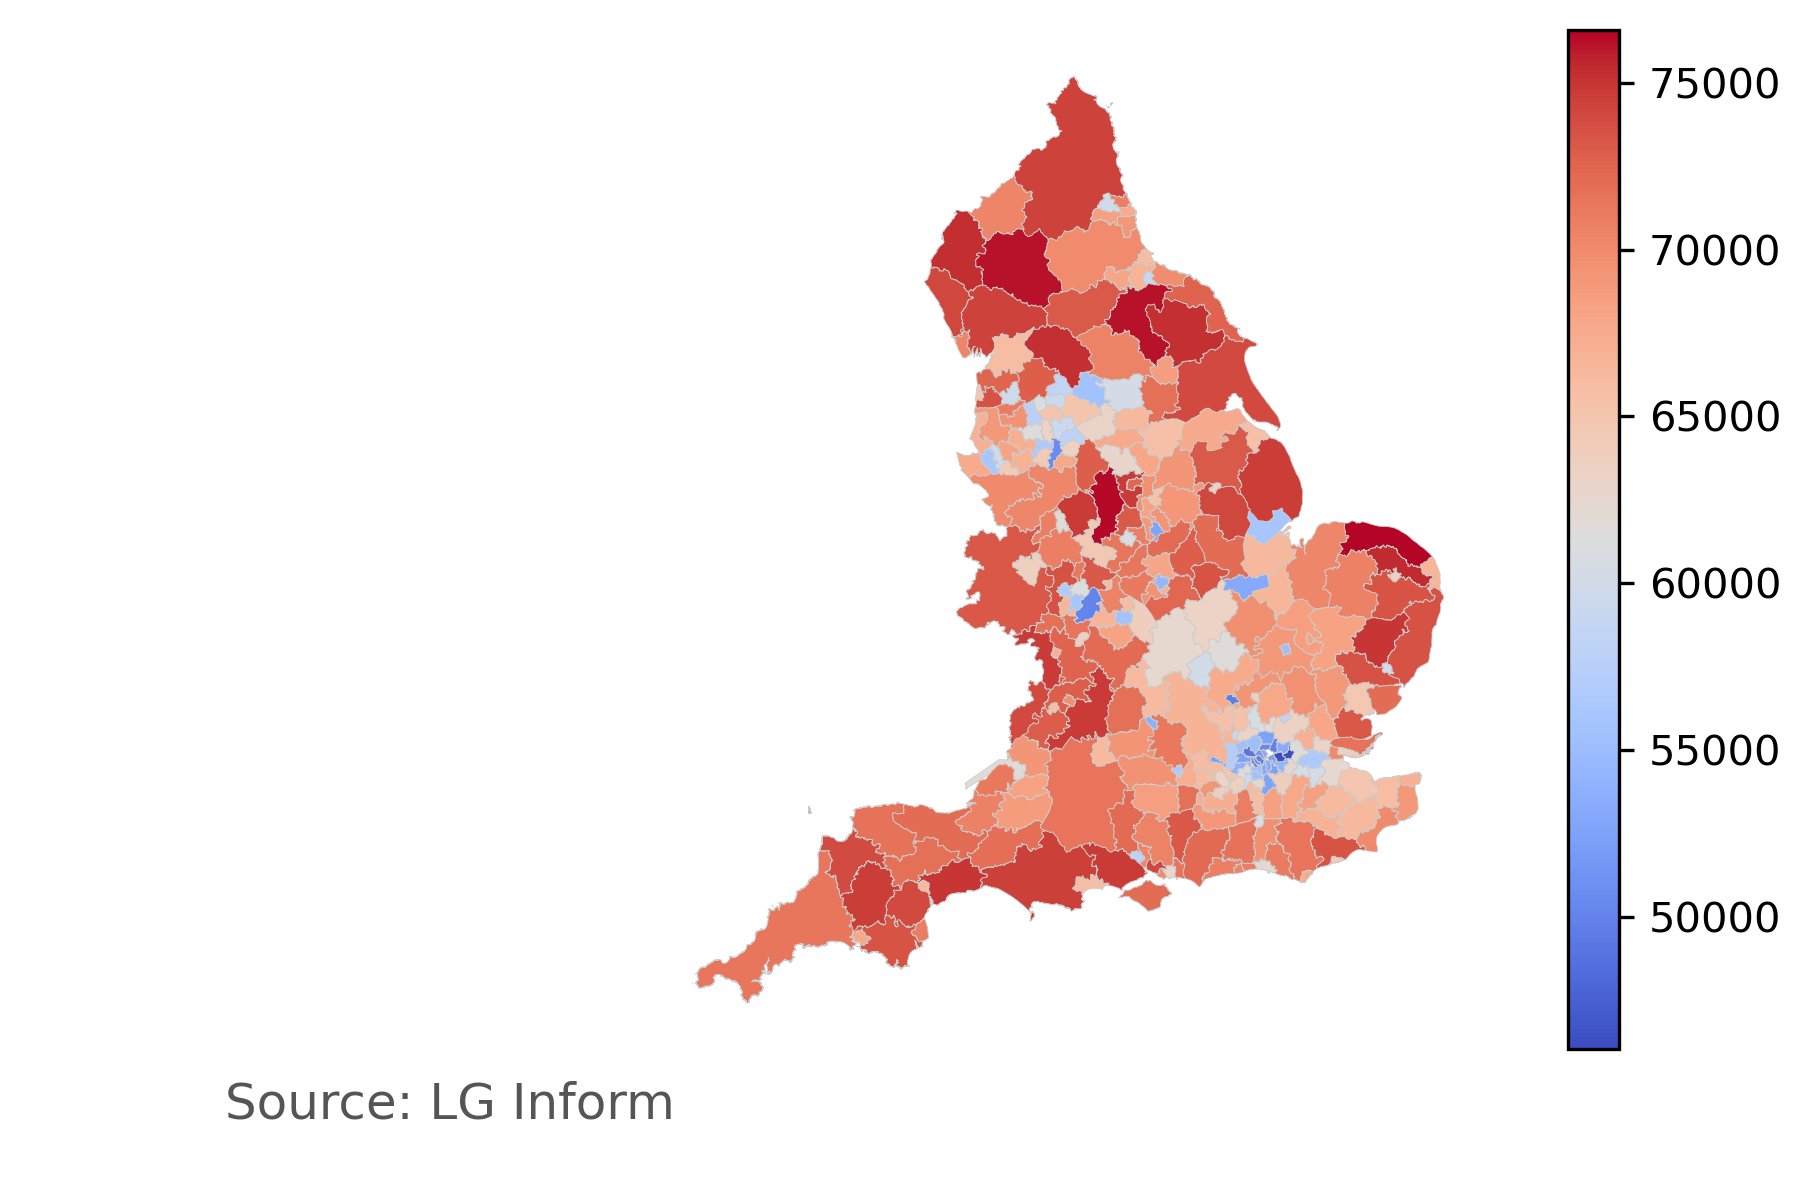

In [105]:
plotmap(variable='Cumulative 1st dose per 100k', df=merged, 
        title='Cumulative 1st dose per 100k per Local Authority', output_file="dose1_per_100k_map_la.png")

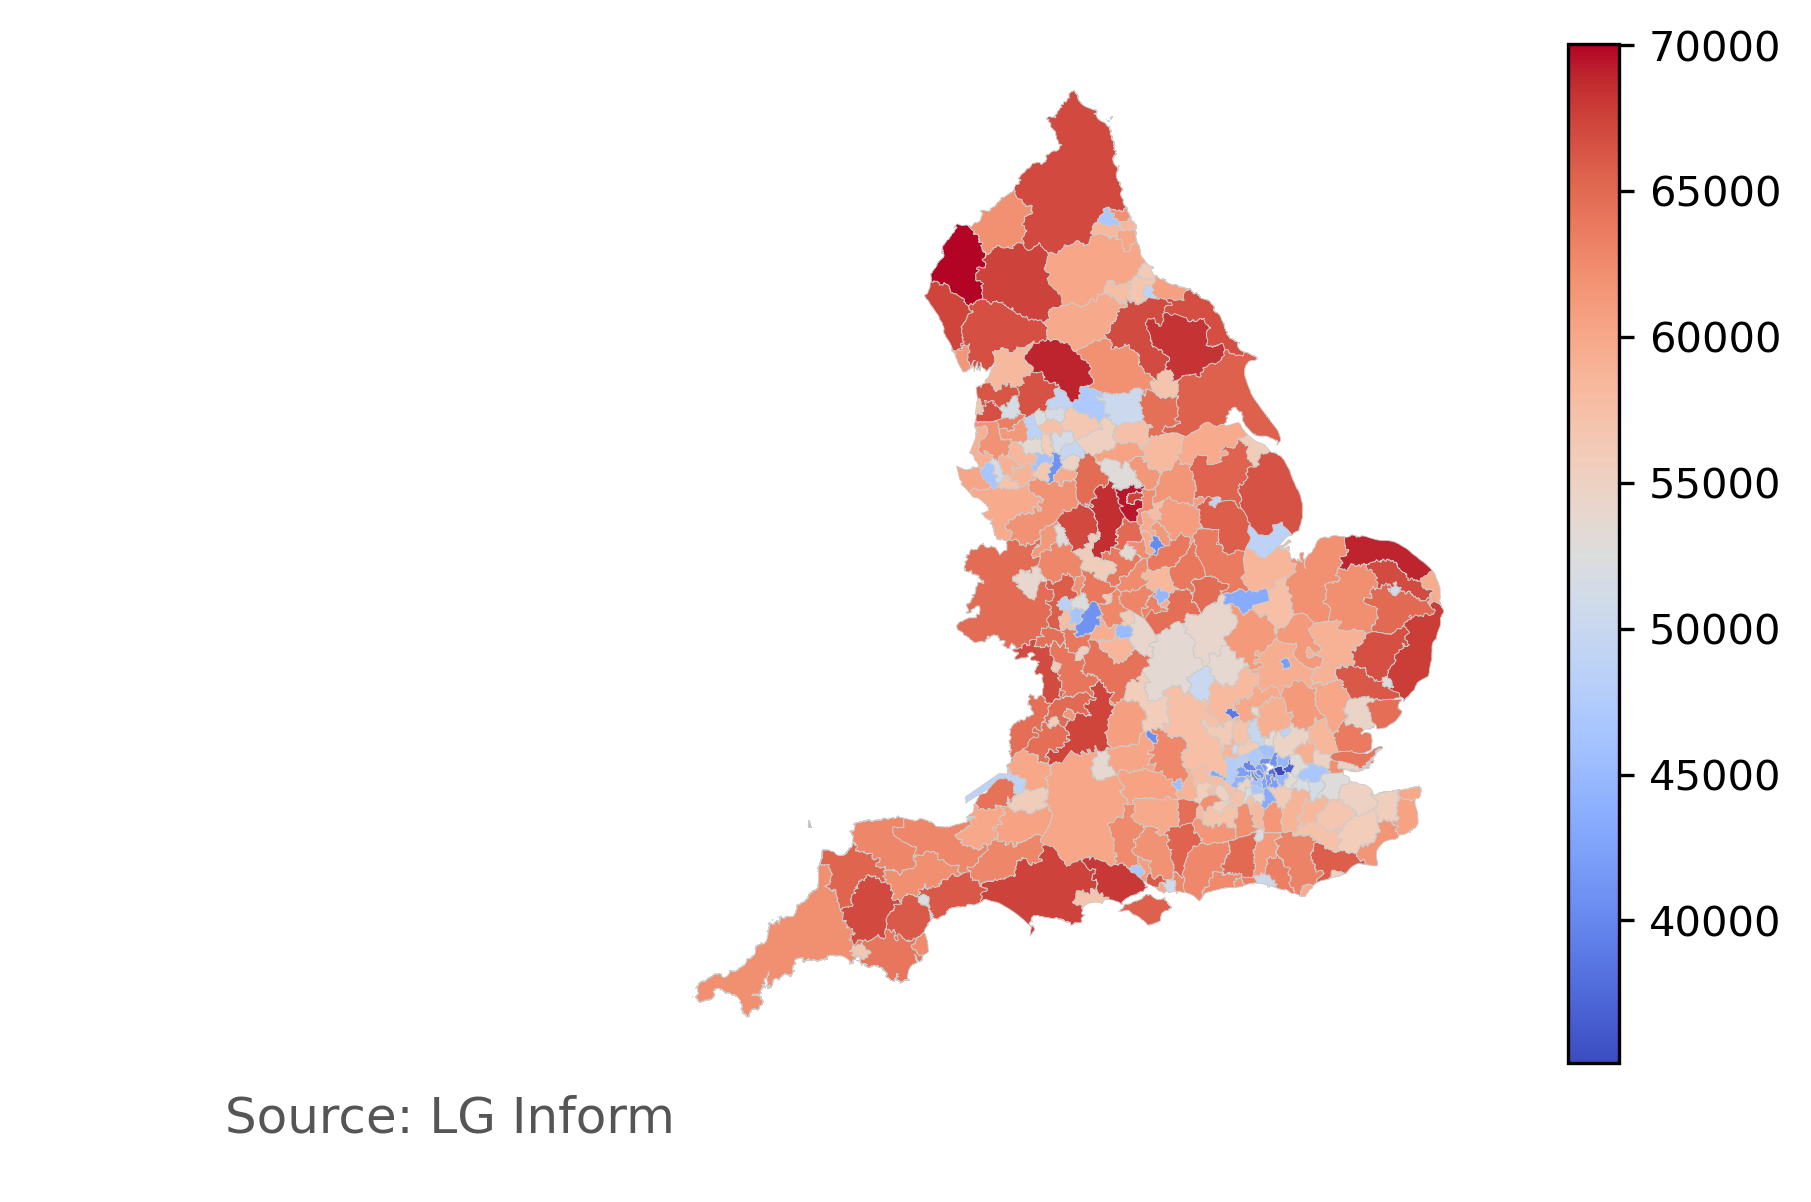

In [106]:
plotmap(variable='Cumulative 2nd dose per 100k', df=merged, 
        title='Cumulative 2nd dose per 100k per Local Authority', output_file="dose2_per_100k_map_la.png")

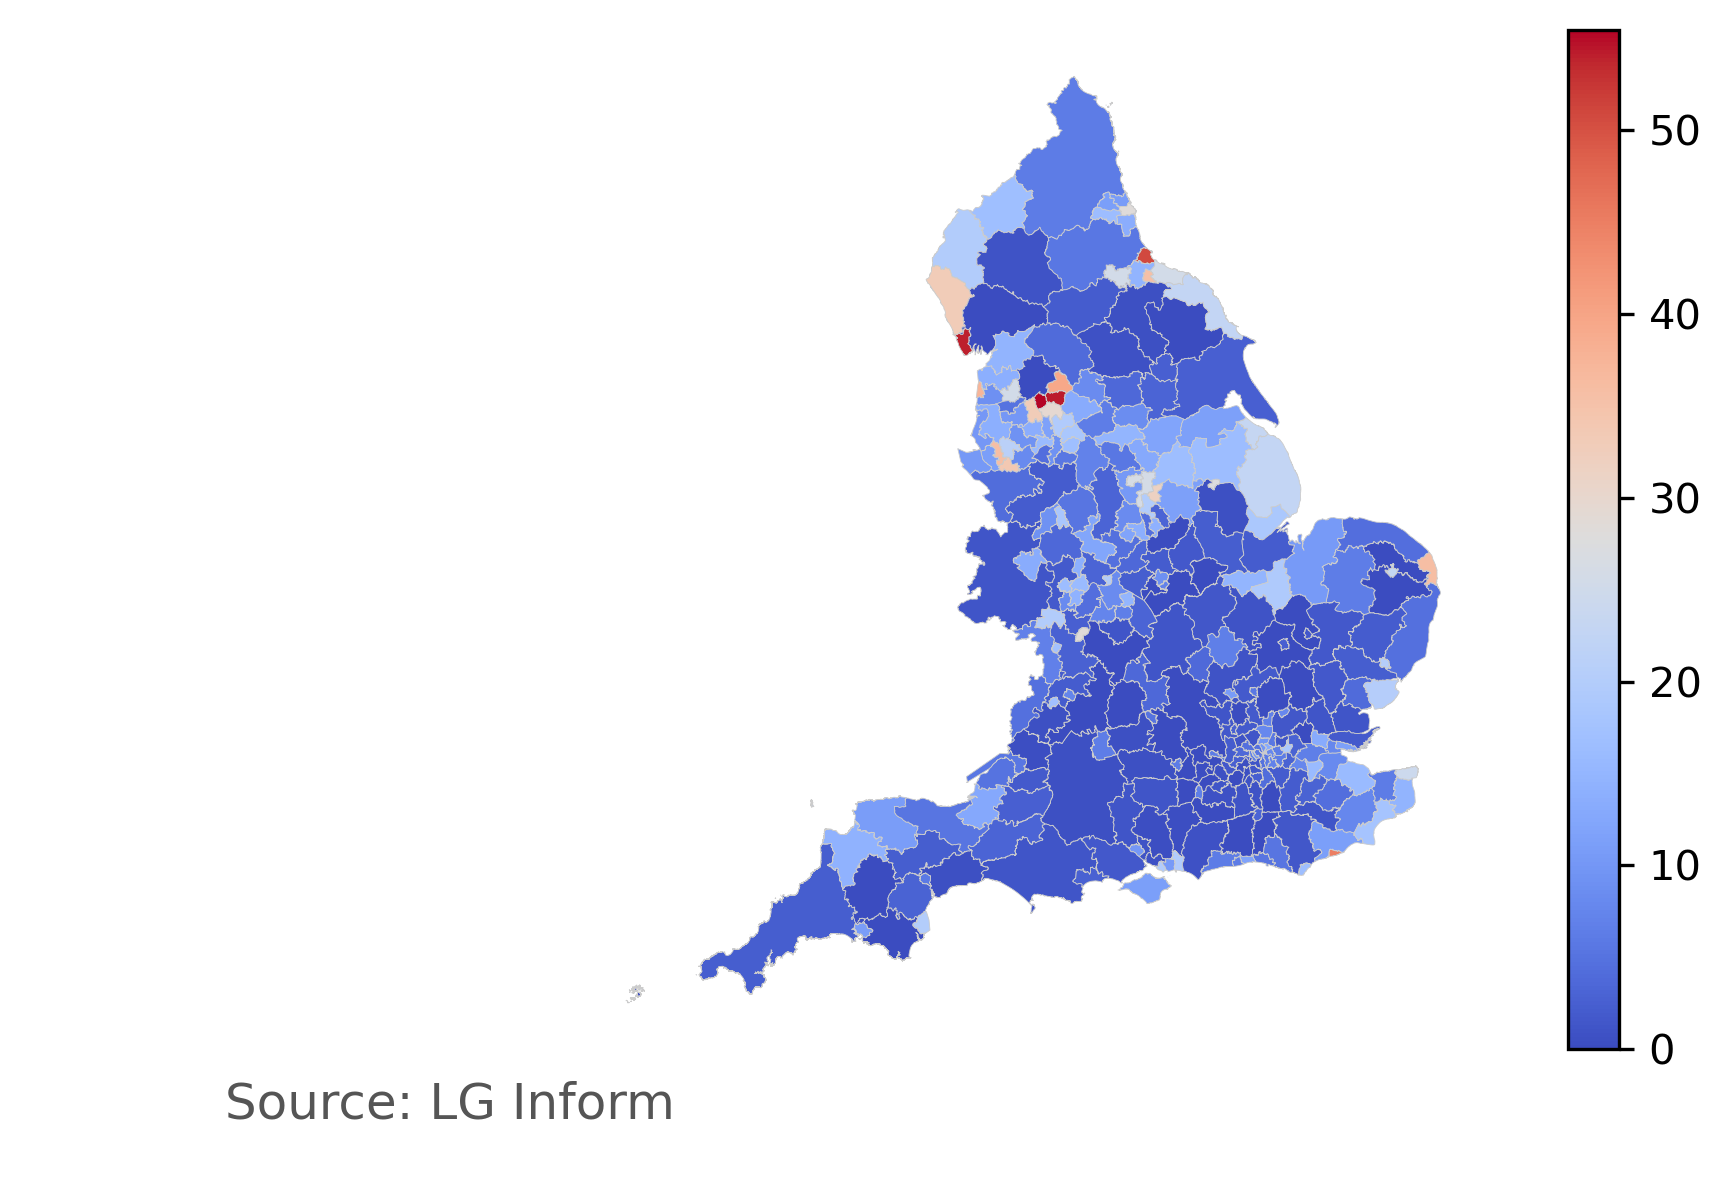

In [107]:
plotmap(variable='IMD: Overall - extent (%) per 100k', df=merged, 
        title='IMD: Overall - extent (%) per 100k per Local Authority', output_file="IMD_per_100k_map_la.png")

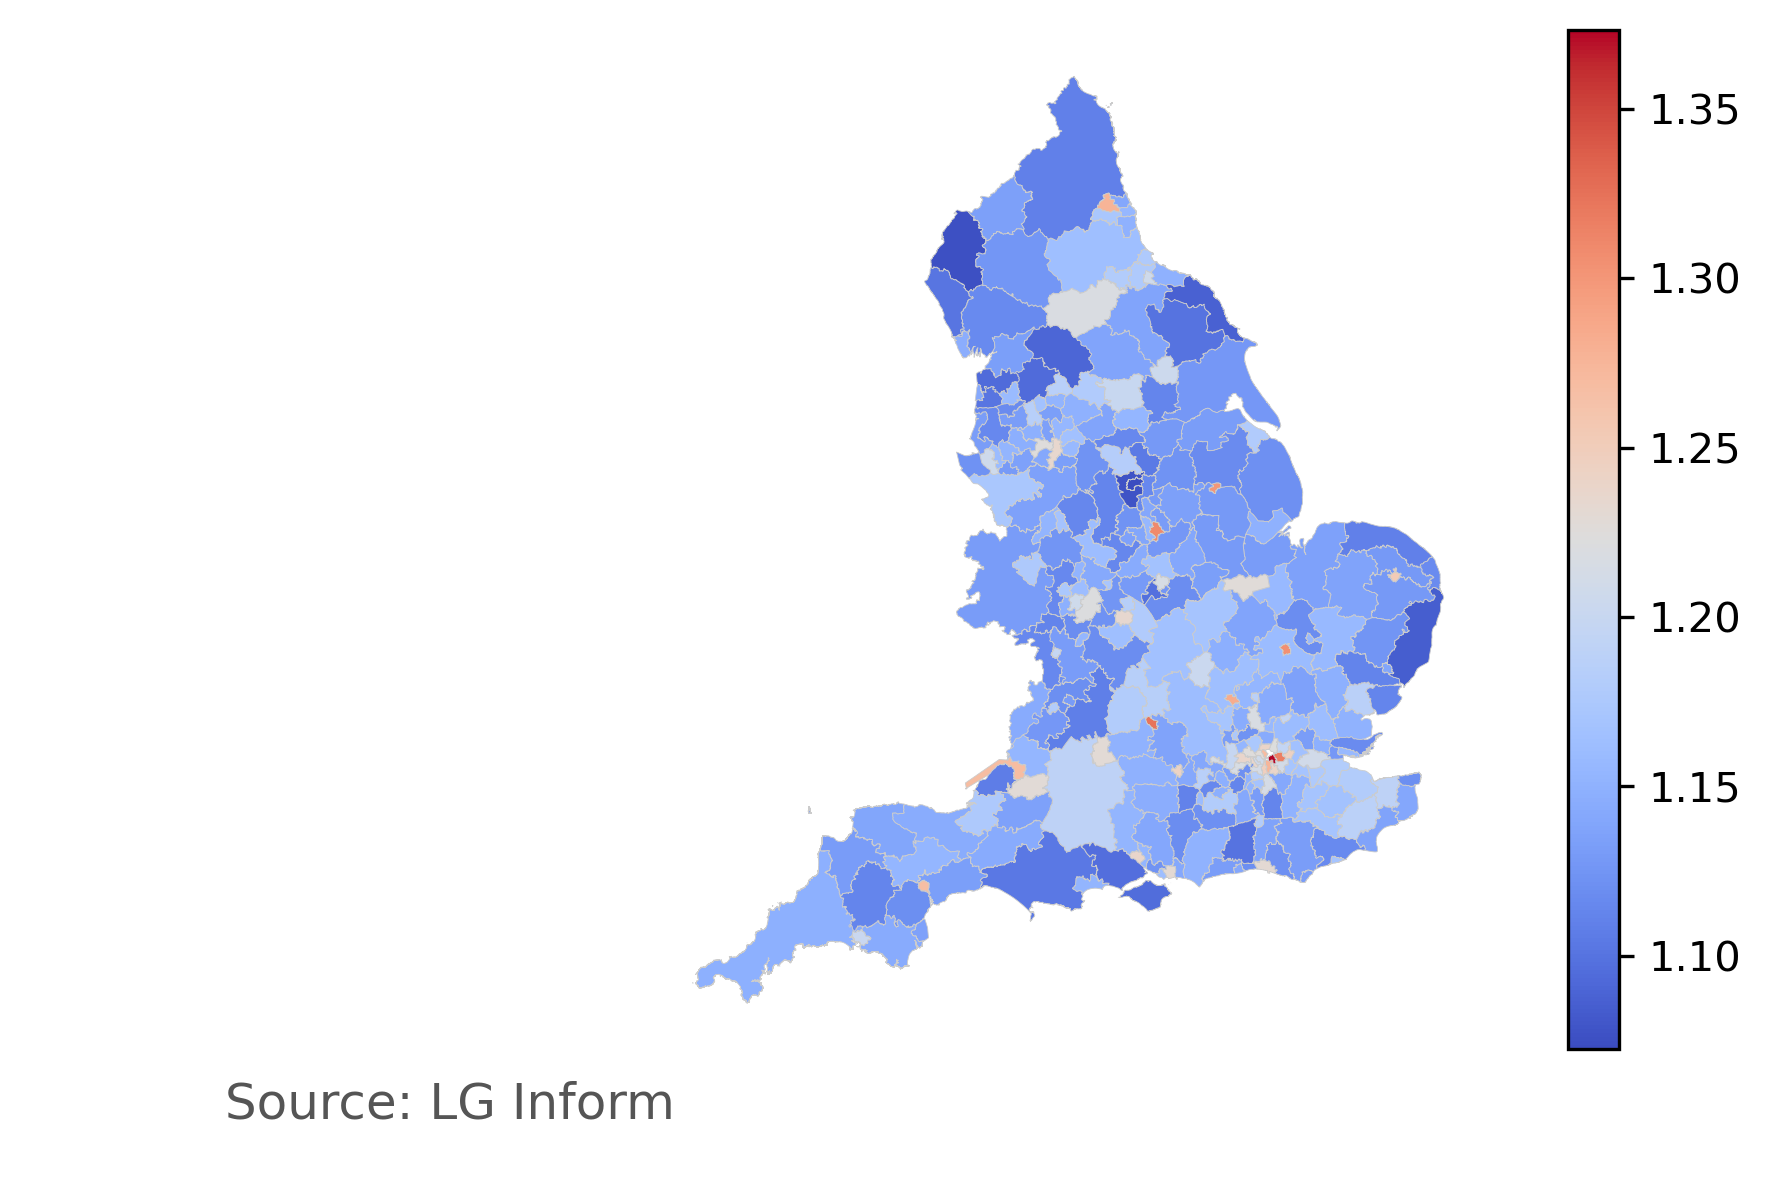

In [108]:
plotmap(variable='Cumulative 1st dose by Cumulative 2nd dose', df=merged, 
        title='Cumulative 1st dose by Cumulative 2nd dose per Local Authority', output_file="dose1_by_dose2_per_100k_map_la.png")

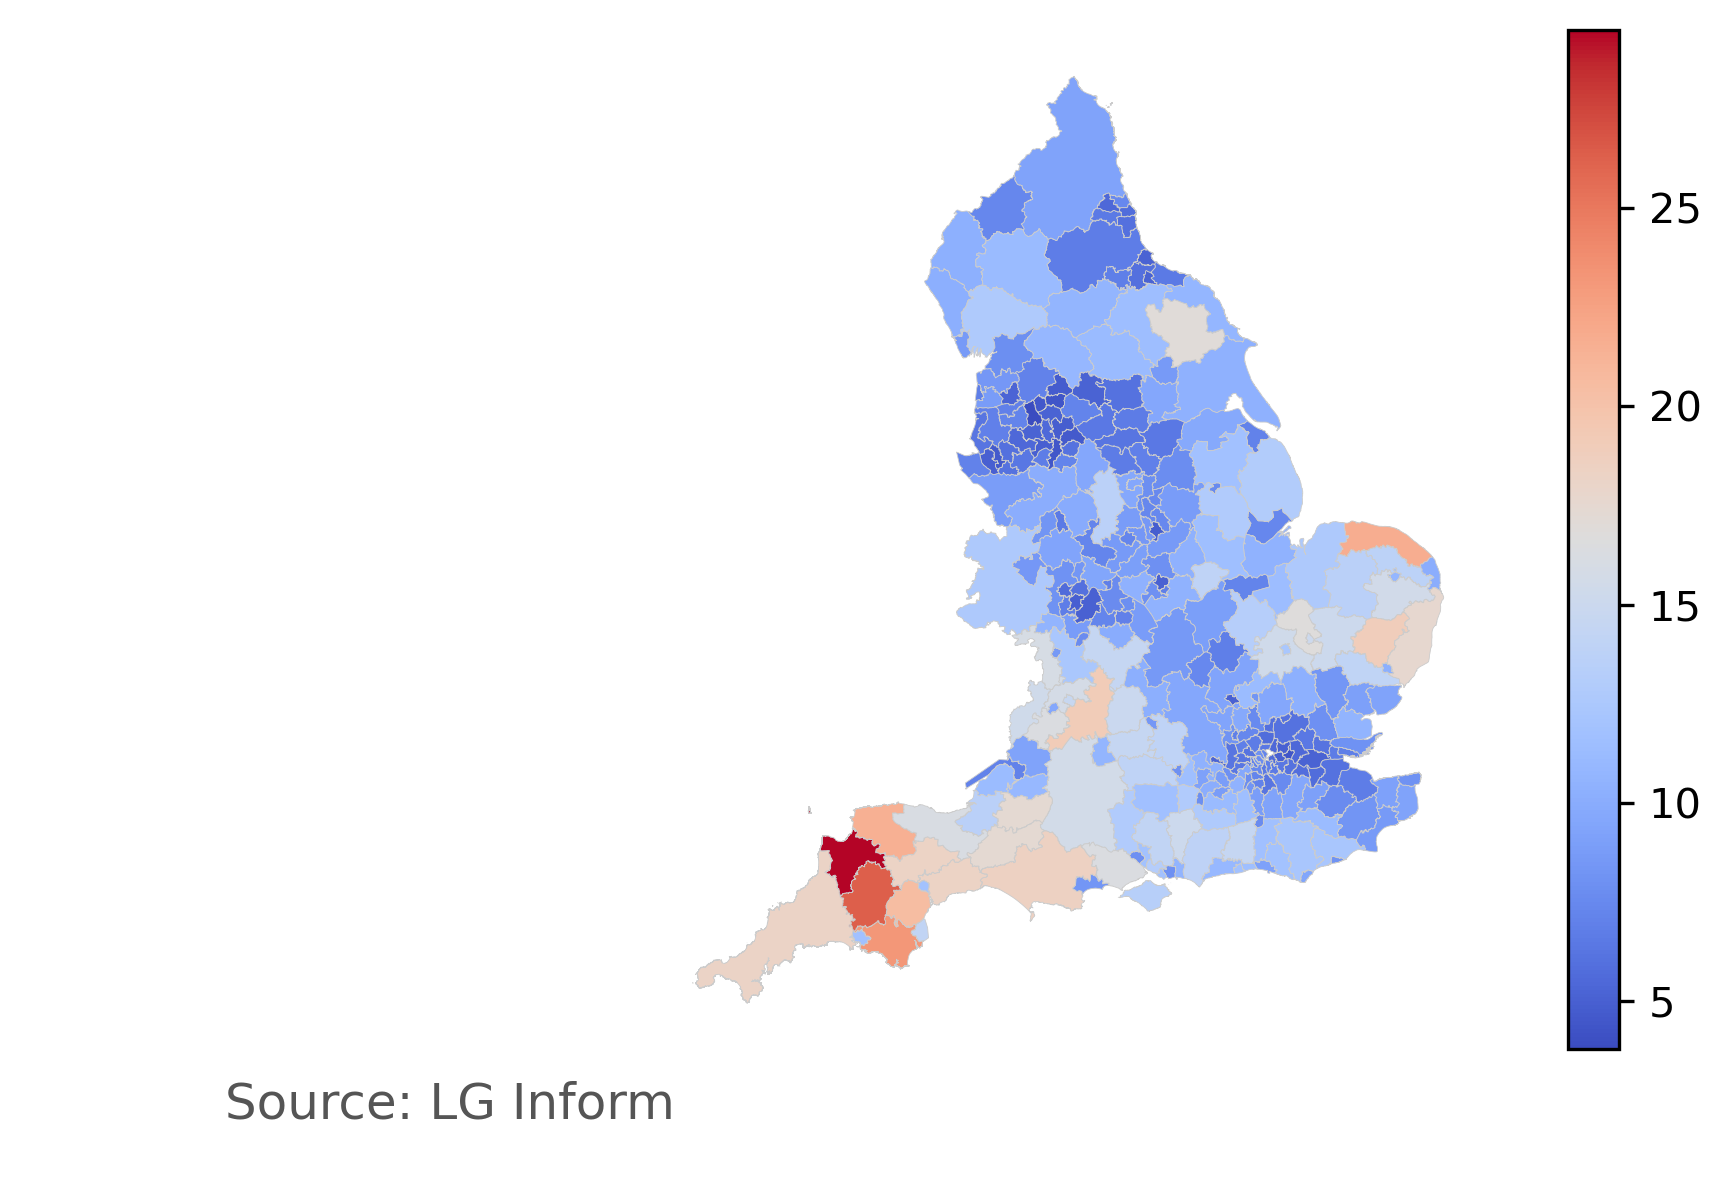

In [109]:
plotmap(variable='Cumulative 1st dose by Cumulative confirmed cases', df=merged, 
        title='Cumulative 1st dose by Cumulative confirmed cases per Local Authority', output_file="dose1_by_cases_per_100k_map_la.png")

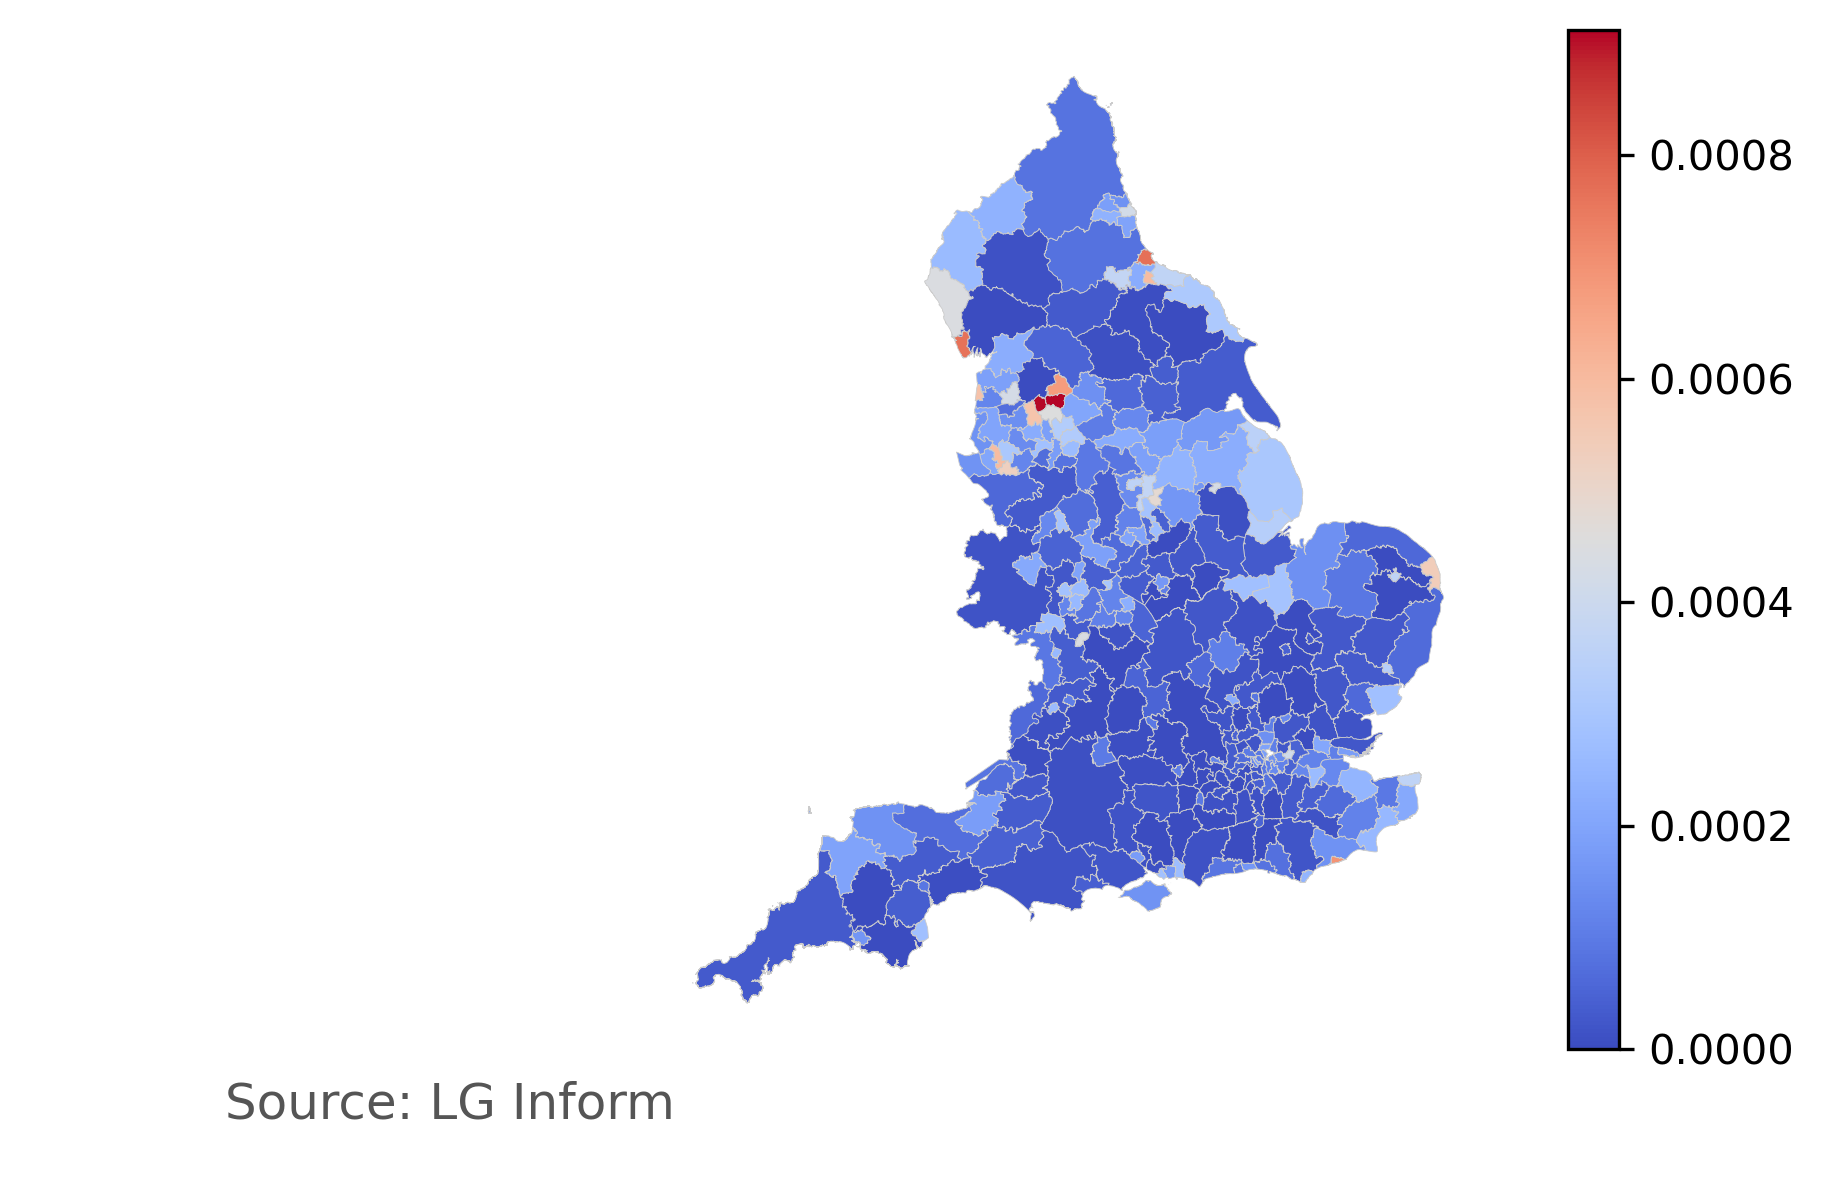

In [110]:
plotmap(variable='IMD: Overall - extent (%) by Cumulative 1st dose', df=merged, 
        title='IMD: Overall - extent (%) by Cumulative 1st dose per Local Authority', output_file="imd_per_100k_by_dose1_map_la.png")

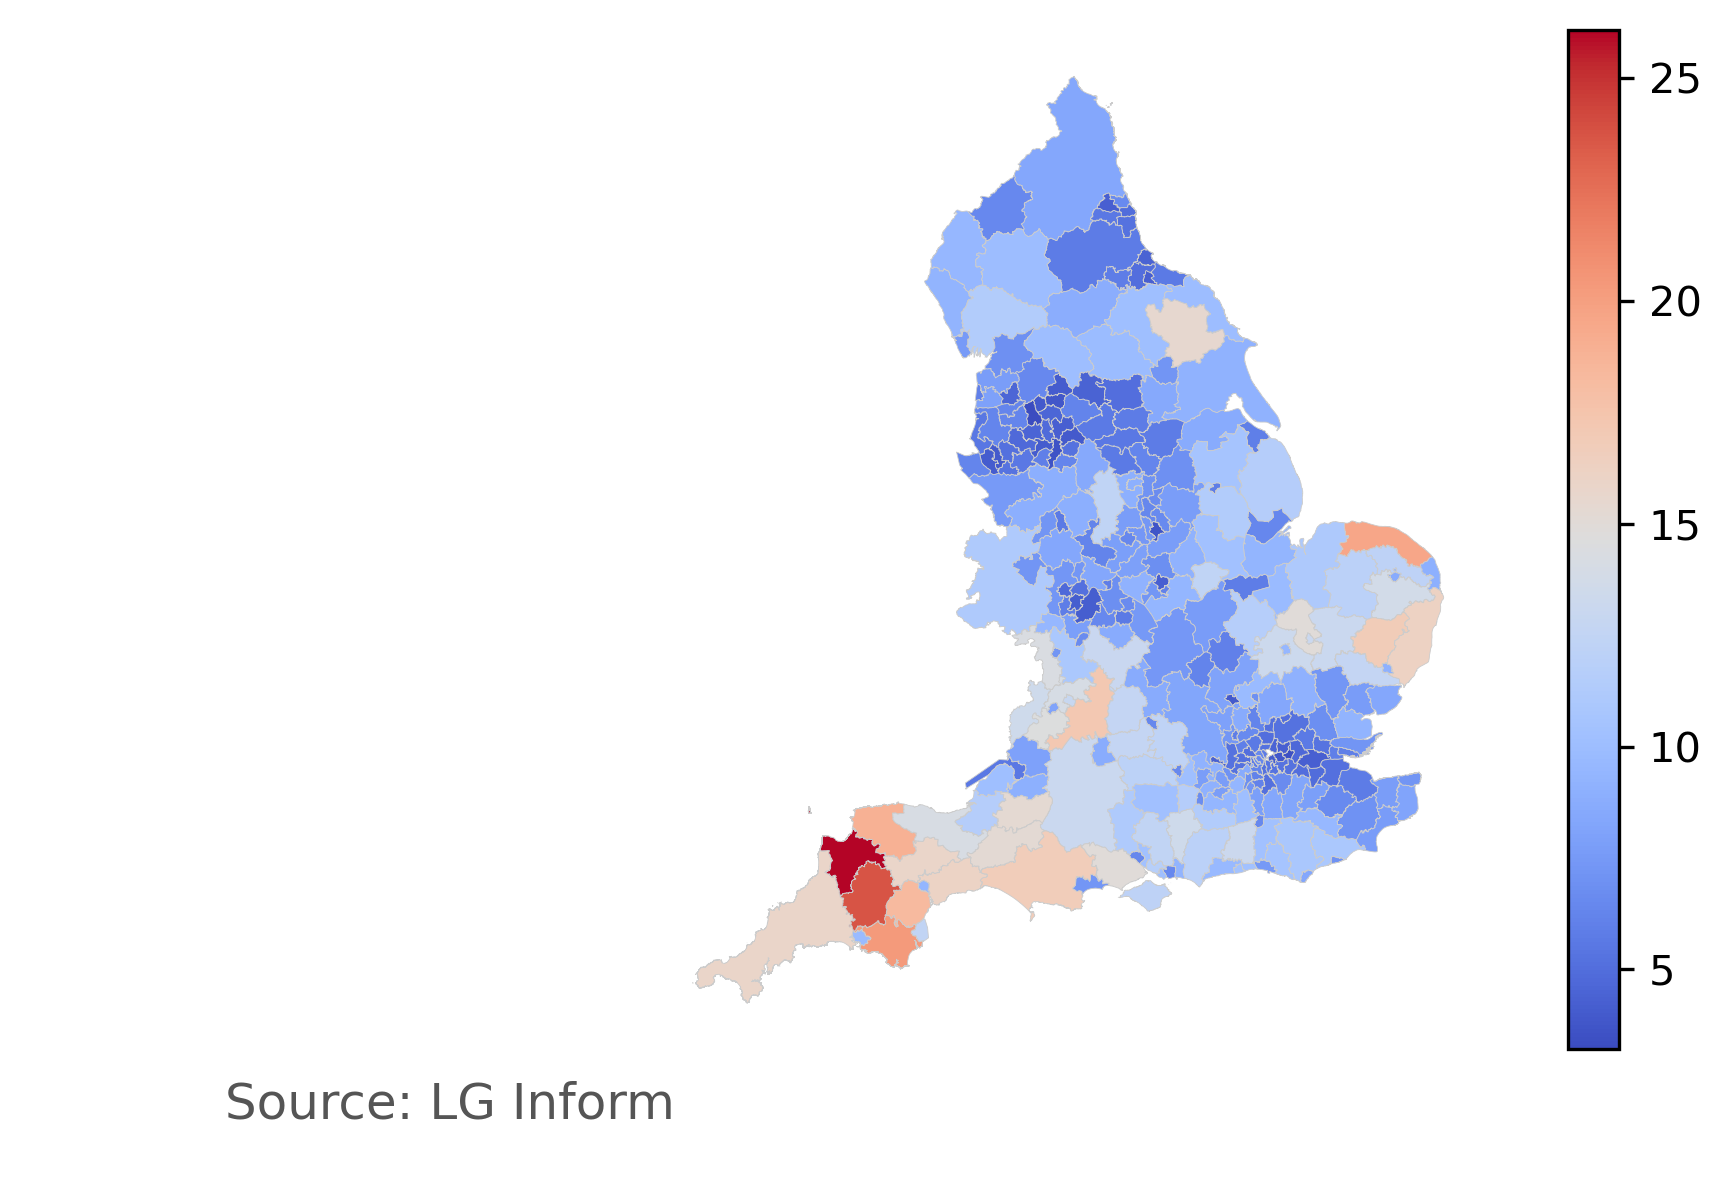

In [111]:
plotmap(variable='Cumulative 2nd dose by Cumulative confirmed cases', df=merged, 
        title='Cumulative 2nd dose by Cumulative confirmed cases per Local Authority', output_file="dose2_by_cases_per_100k_map_la.png")

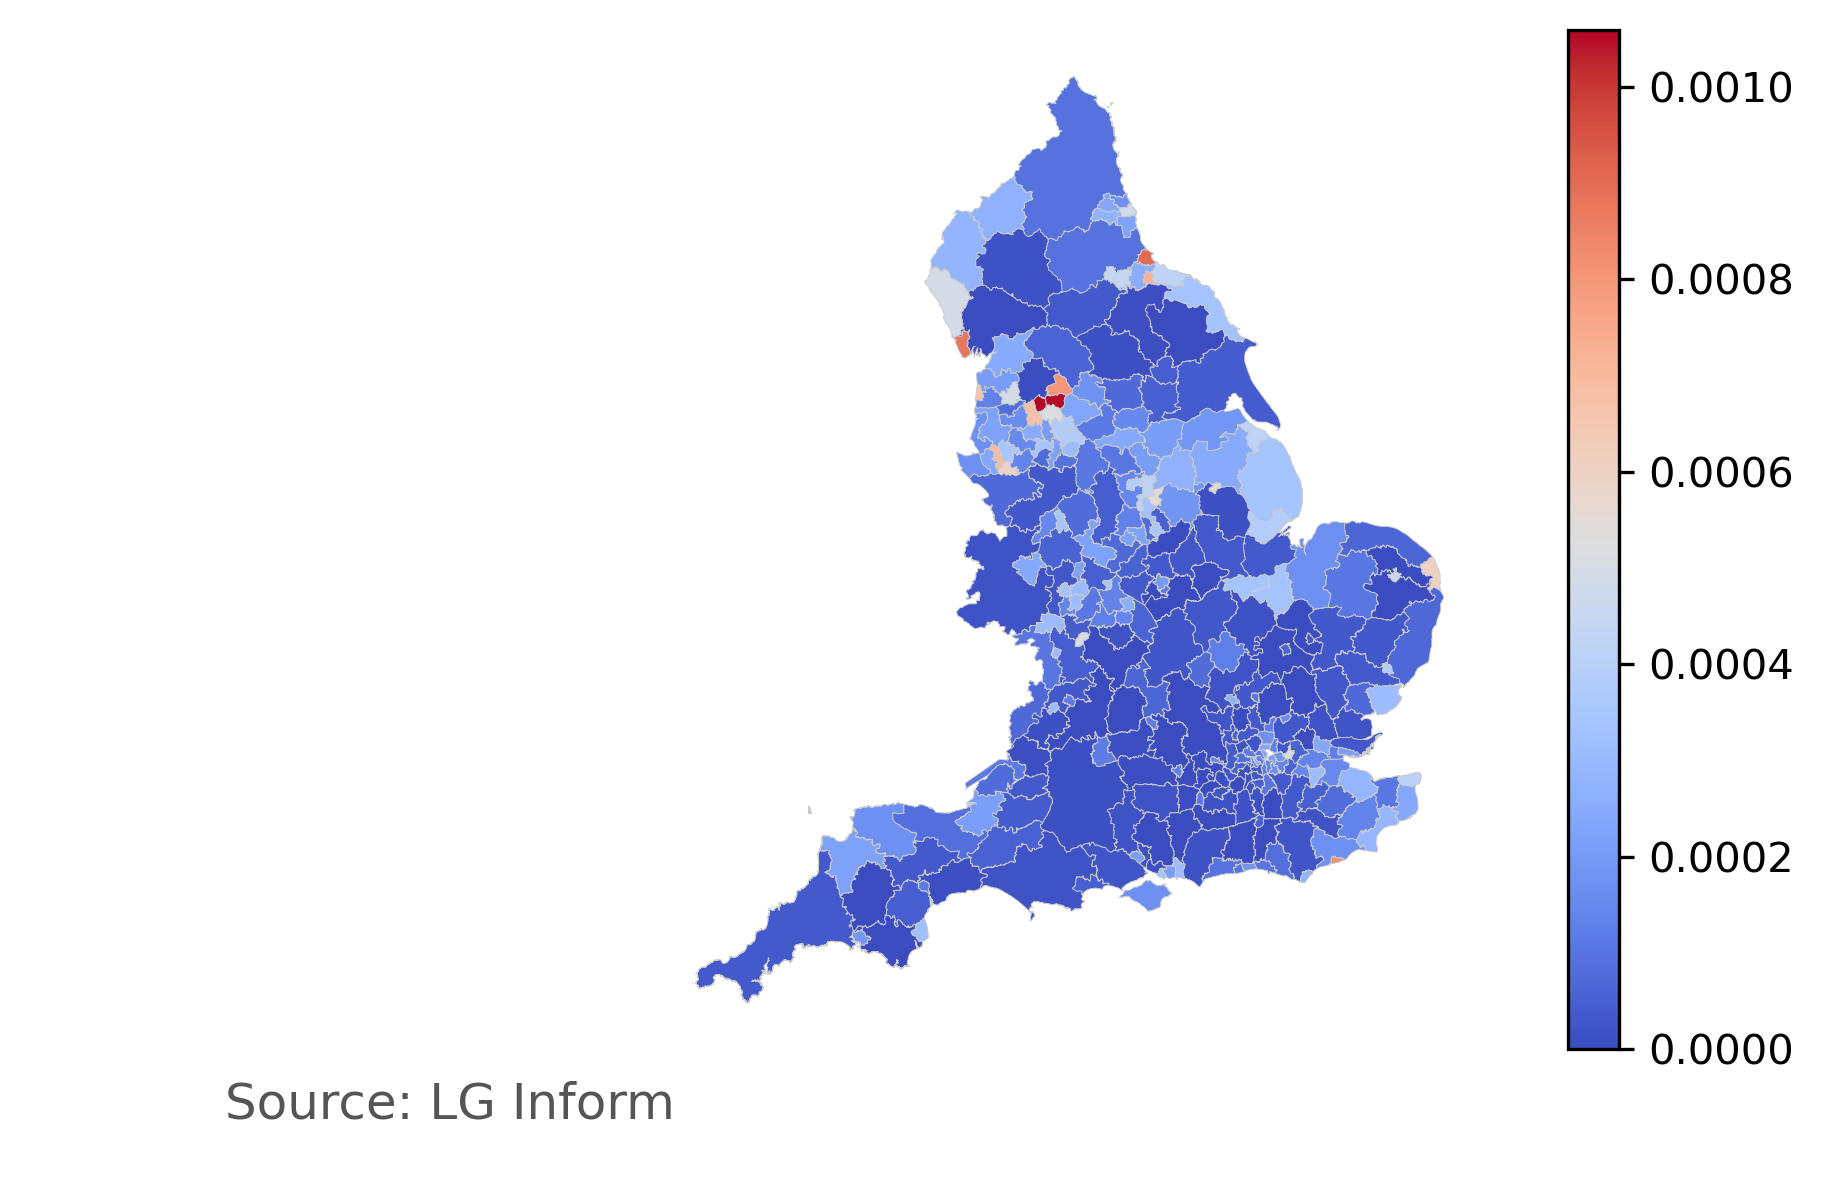

In [112]:
plotmap(variable='IMD: Overall - extent (%) by Cumulative 2nd dose', df=merged, 
        title='IMD: Overall - extent (%) by Cumulative 2nd dose per Local Authority', output_file="imd_per_100k_by_dose2_map_la.png")

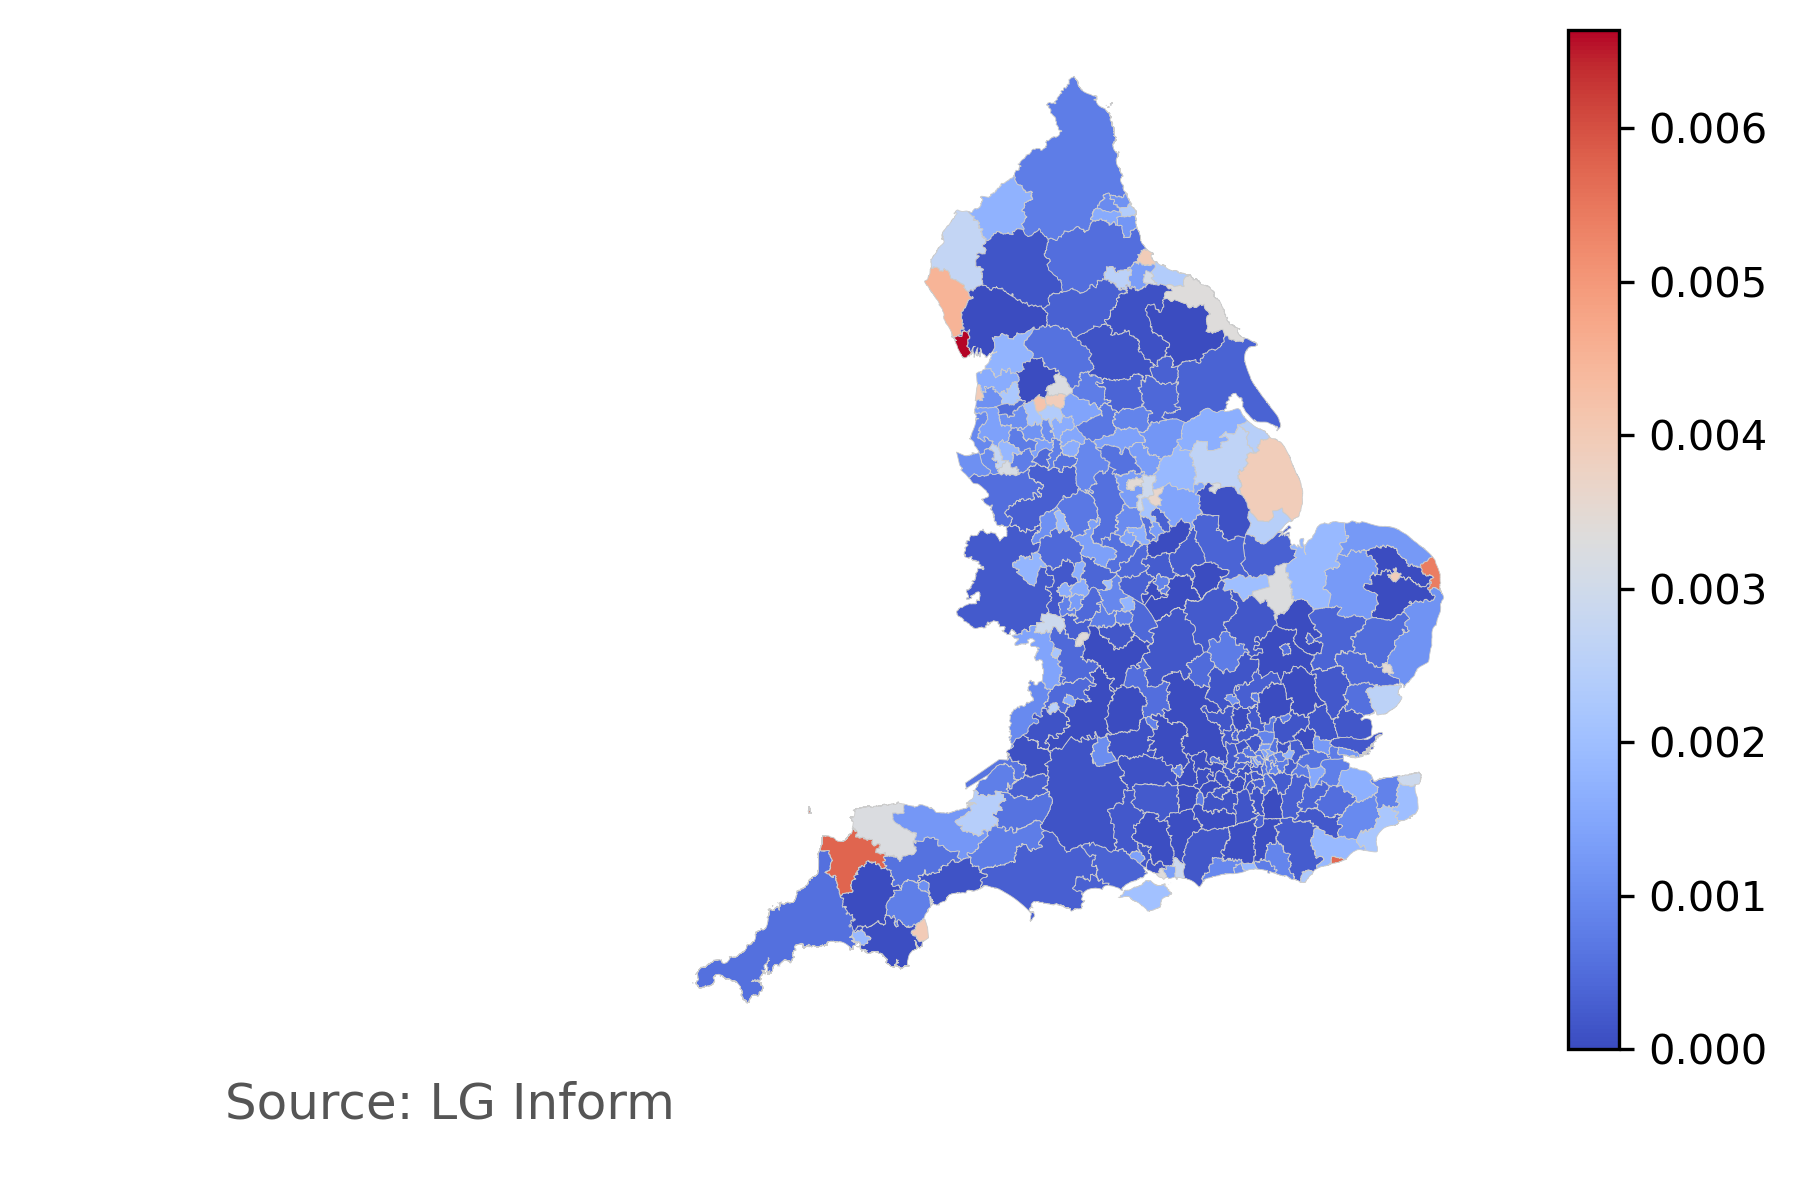

In [113]:
plotmap(variable='IMD: Overall - extent (%) by Cumulative confirmed cases', df=merged, 
        title='IMD: Overall - extent (%) by Cumulative confirmed cases per Local Authority', output_file="imd_per_100k_by_cases_map_la.png")